# Imports and initializations

In [1]:
import numpy as np
import signac as sg
import pickle
from itertools import product, combinations, accumulate, groupby
from matplotlib import pyplot as plt
from matplotlib import cm, colors
from matplotlib.ticker import PercentFormatter
from project import spherical_to_cartesian, get_cross_limits
import sys
import os

In [2]:
project = sg.get_project()

# Read in shared data
sd_fn = project.fn('shared_data.h5')
with sg.H5Store(sd_fn).open(mode='r') as sd:
    adj_mats = np.array(sd['adj_mats'])
    modules = np.array([i.decode() for i in sd['modules']])
    cross_labels = np.array([i.decode() for i in sd['cross_labels']])
    C_offdiags = list(sd['C_offdiags'])

diagrams = ['w\n|\nv\n|\nu', 'w   v\n \ /\n  u', '  w\n / \\\nu   v', '  w\n / \\\nu - v']
spec_labels = ['u', 'v', 'w']
C_offdiags_labels = [r'$C_{{{}{}}}$'.format(spec_labels[C_ij[0]], spec_labels[C_ij[1]]) for C_ij in C_offdiags]
n_cross_arr = np.arange(0, len(C_offdiags)+1)
# Define q values which yield mean (expected) values for each possible number of nonzero cross diffusive elements
q_expected_arr = np.linspace(0, 1, len(C_offdiags)+1)
C_elements = np.array(C_offdiags + [[i,i] for i in range(3)])
constraint_keys = ['unconstrained', 'constrained']

In [3]:
project.config

_ProjectConfig({'project': 'None', 'schema_version': '1', 'workspace_dir': 'workspace', 'project_dir': '/Users/patrick/Research/Anderson/SmallWebProject/cross_diffusion/bifurcation_surface', 'General': {'default_host': None}, 'hosts': {}})

In [6]:
'''Change statepoint values, be careful!'''
# for job in project:
#     job.update_statepoint({'method': 'symbolic'}, overwrite=True)

In [8]:
'''Reset all data; Only run if you're really sure!!'''
# for job in project:
#     with job.data:
#         keys = list(job.data.keys())
#         for key in keys:
#             if key != 'J':
#                 del job.data[key]
#     for key in list(job.doc.keys()):
#         job.doc.pop(key)

In [79]:
import psutil; import os; print('Total memory in use:', psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)

Total memory in use: 128.1875


# Many parameterizations

## Robustness distribution statistics

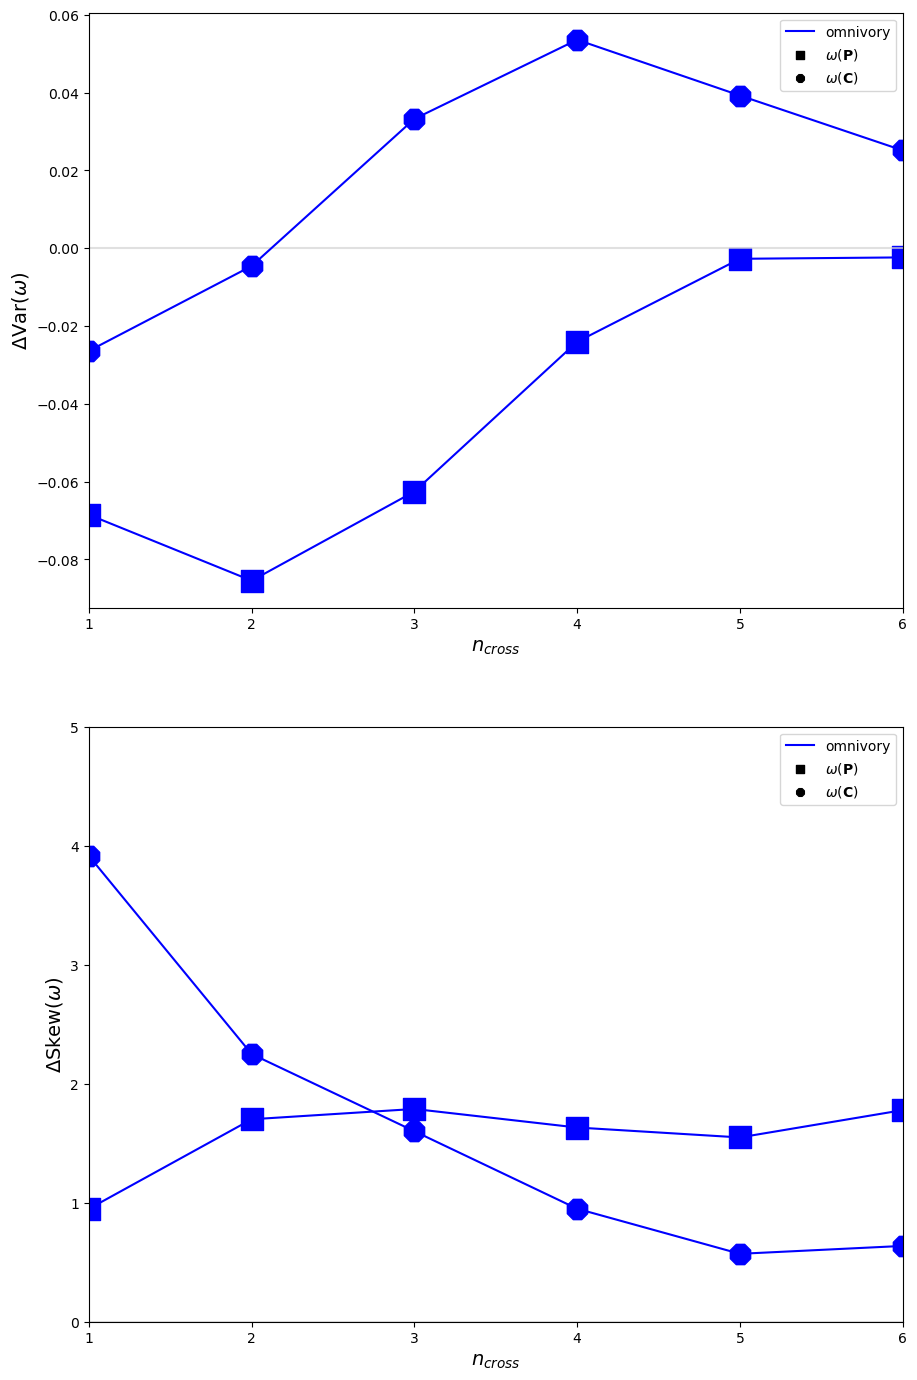

In [5]:
savefig = False
figpath = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
figfn = 'robustness_stats_diff.png'
plt.figure(figsize=(10.5*1, 8.5*2))
axfontsize = 14
# color = 'cornflowerblue'
colors = ['red', 'orange', 'green', 'blue']
constraint_keys = ['constrained', 'unconstrained']
markersize = 250
with sg.H5Store('robustness.h5').open(mode='r') as rob_data:
    for stat_idx, stat_key in enumerate(['variance', 'skewness']):
        ax = plt.subplot(2, 1, stat_idx + 1)
        ax.axhline(0, ls='-', color='lightgrey', alpha=0.7)
        for module_idx, module in enumerate(modules):
            if module != 'omnivory':
                continue
            for rob_idx, rob_key in enumerate(['local', 'spatial']):
                for cons_idx, cons_key in enumerate(constraint_keys):
                    data_key = '{}/{}/{}/{}'.format(module,stat_key,rob_key,cons_key)
                    stat_data = np.array(rob_data[data_key])
                    # print(stat_data); sys.exit()
                    if cons_key == 'constrained':
                        diff = stat_data
                    else:
                        diff = diff - stat_data
                marker = 's' if rob_key == 'local' else '8'
                # if rob_key == 'local':
                #     label = r'$\omega\left(\bf{P}\right)$'
                # else: 
                #     label = r'$\omega\left(\bf{C}\right)$'
                ax.plot(n_cross_arr, diff, color=colors[module_idx])
                ax.scatter(n_cross_arr, diff, s=markersize, color=colors[module_idx], marker=marker)
            ax.plot([], [], color=colors[module_idx], label=module)
        ax.scatter([], [], color='black', marker='s', label=r'$\omega\left(\bf{P}\right)$')
        ax.scatter([], [], color='black', marker='8', label=r'$\omega\left(\bf{C}\right)$')
        ax.set_xlabel(r'$n_{cross}$', fontsize=14)
        ax.set_xlim(1,6)
        stat_key_abbr = 'Var' if stat_key == 'variance' else 'Skew'
        # mat_key = 'P' if rob_idx == 'local' else 'C'
        ylabel = r'$\Delta$' + stat_key_abbr + r'$(\omega)$'
        ax.set_ylabel(ylabel, fontsize=axfontsize)
        if stat_key == 'skewness':
            ax.set_ylim(0, 5)
        ax.legend()
            #     ylim = (0,0.17) if stat_key == 'variance' else (-1.5,16)
            #     ax.set_ylim(ylim)
if savefig:
    plt.savefig(figpath + figfn, bbox_inches='tight')

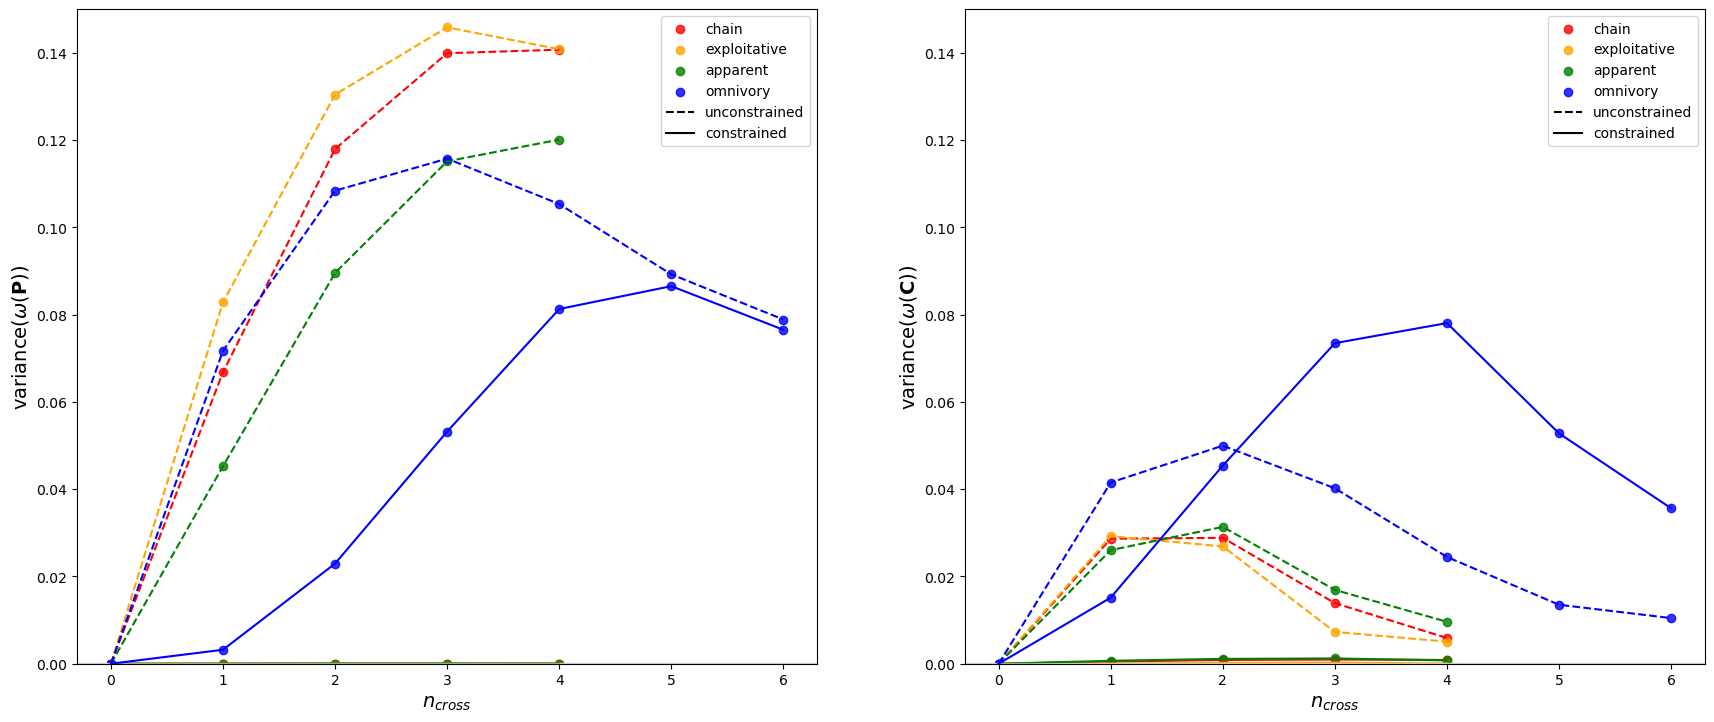

In [6]:
savefig = False
figpath = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
figfn = 'robustness_stats.png'
plt.figure(figsize=(10.5*2, 8.5*1))
axfontsize = 14
colors = ['red', 'orange', 'green', 'blue']
with sg.H5Store('robustness.h5').open(mode='r') as rob_data:
    for stat_idx, stat_key in enumerate(['variance']):
        for module_idx, module in enumerate(modules):
            for rob_idx, rob_key in enumerate(['local', 'spatial']):
                ax = plt.subplot(1, 2, rob_idx + 1)
                ax.axhline(0, ls='-', color='lightgrey', alpha=0.7)
                for cons_key in constraint_keys:
                    data_key = '{}/{}/{}/{}'.format(module,stat_key,rob_key,cons_key)
                    stat_data = np.array(rob_data[data_key])
                    ls = '--' if cons_key == 'unconstrained' else '-'
                    color = 'cornflowerblue'
                    ax.plot(n_cross_arr, stat_data, ls=ls, color=colors[module_idx])
                    if cons_key == 'constrained':
                        label = module
                    else:
                        label = ''
                    ax.scatter(n_cross_arr, stat_data, color=colors[module_idx], alpha=0.8, label=label)
                    ax.set_xlabel(r'$n_{cross}$', fontsize=14)
                    if rob_key == 'local':
                        ylabel = '{}'.format(stat_key) + r'$\left(\omega\left(\bf{P}\right)\right)$'
                    else: 
                        ylabel = '{}'.format(stat_key) + r'$\left(\omega\left(\bf{C}\right)\right)$'
                    ax.set_ylabel(ylabel, fontsize=14)
                    # ylim = (0,0.14) if stat_key == 'variance' else (-1,14)
                    ylim = (0,0.15) if stat_key == 'variance' else (-1.5,21)
                    ax.set_ylim(ylim)
                if module_idx == 3:
                    ax.plot([], [], ls='--', label='unconstrained', color='black')
                    ax.plot([], [], ls='-', label='constrained', color='black')
                ax.legend()
if savefig:
    plt.savefig(figpath + figfn, bbox_inches='tight')

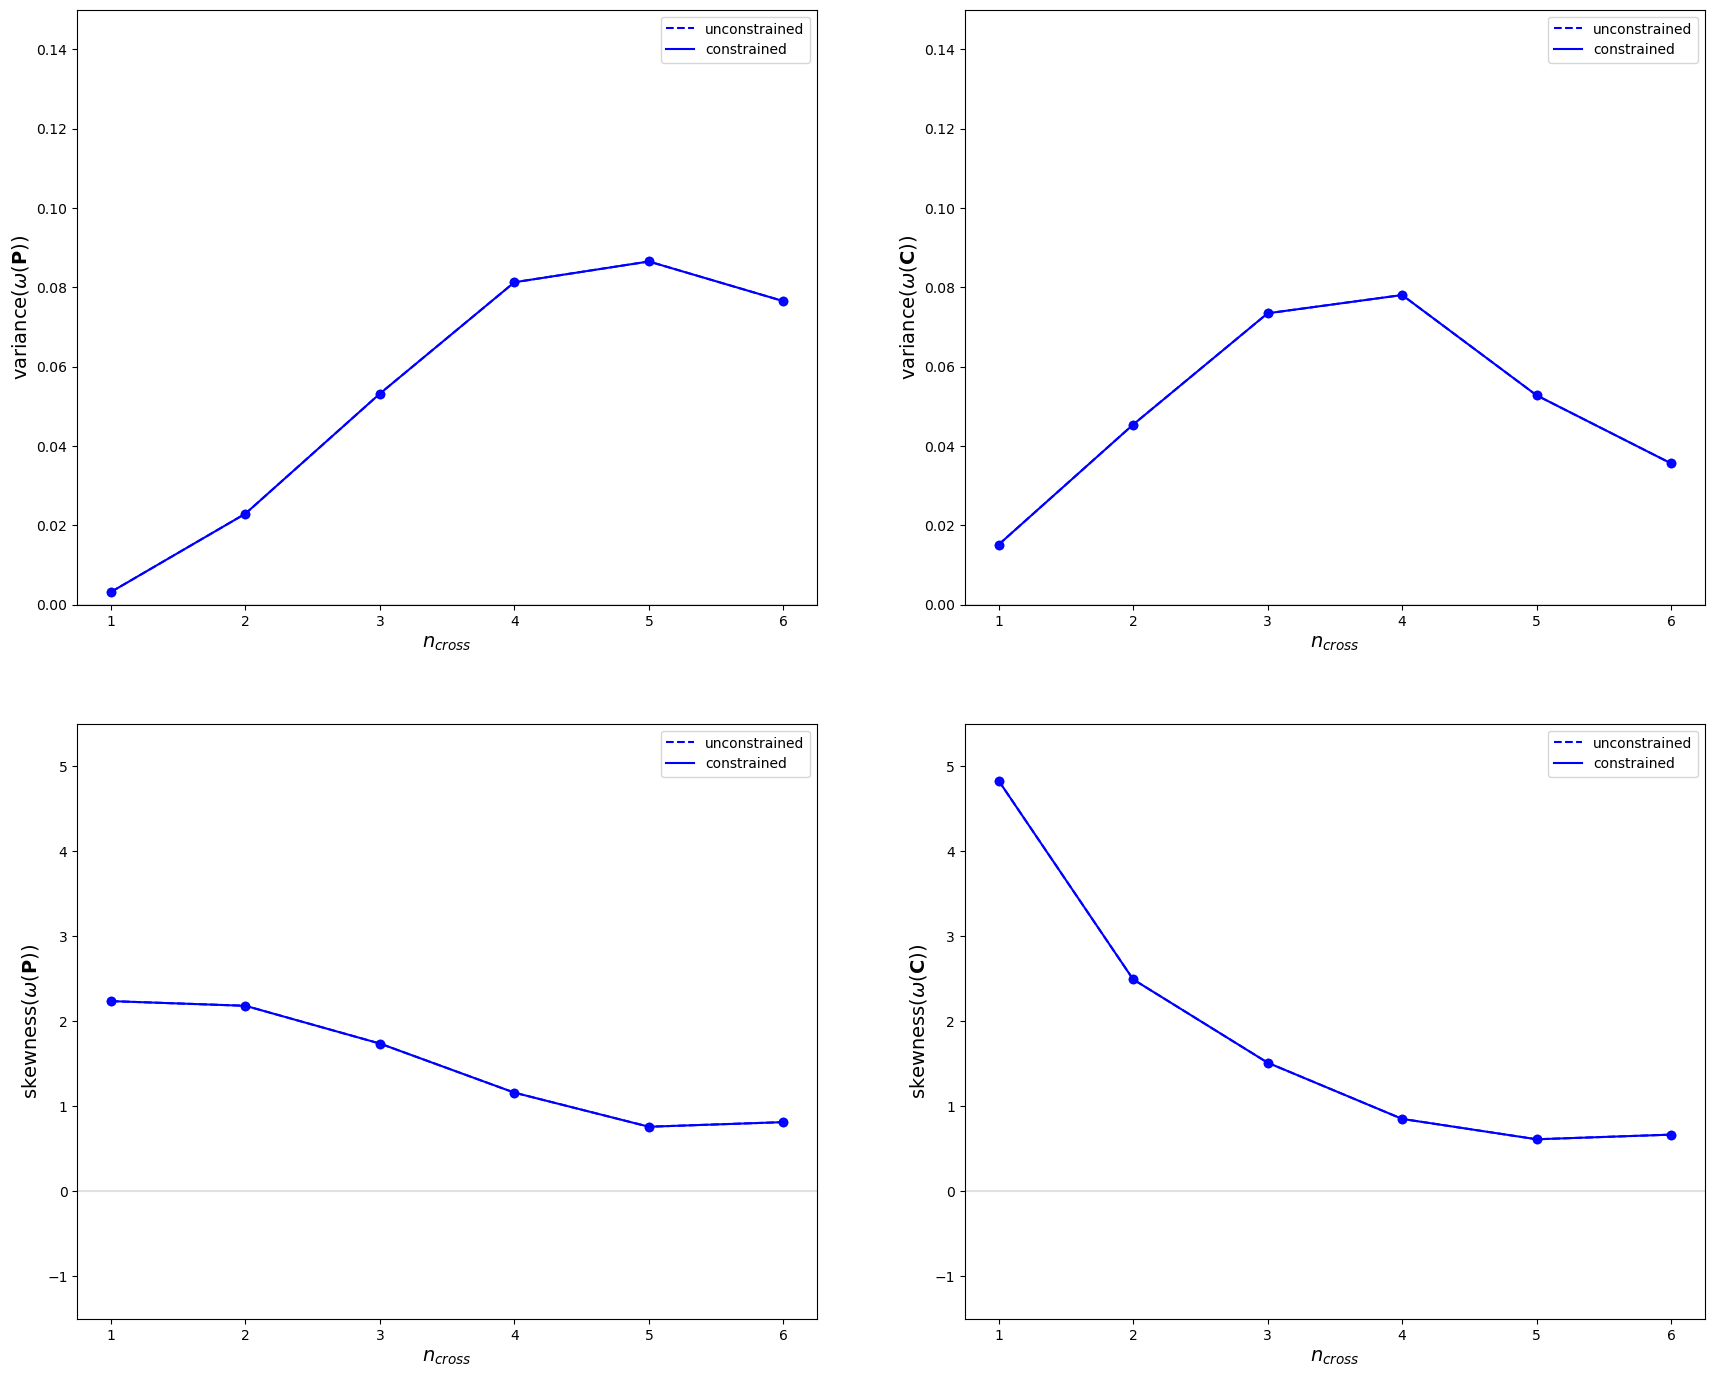

In [6]:
savefig = False
figpath = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
figfn = 'robustness_stats.png'
plt.figure(figsize=(10.5*2, 8.5*2))
axfontsize = 14
colors = ['red', 'orange', 'green', 'blue']
with sg.H5Store('robustness.h5').open(mode='r') as rob_data:
    for stat_idx, stat_key in enumerate(['variance', 'skewness']):
        for module_idx, module in enumerate(modules):
            if module != 'omnivory':
                continue
            for rob_idx, rob_key in enumerate(['local', 'spatial']):
                if stat_idx == 0:
                    plt_idx = rob_idx + 1
                else:
                    plt_idx = rob_idx + 3
                ax = plt.subplot(2, 2, plt_idx)
                ax.axhline(0, ls='-', color='lightgrey', alpha=0.7)
                for cons_key in constraint_keys:
                    # stat_data = [rob_data['{}/{}/{}/{}'.format(str(n_cross),stat_key,rob_key,cons_key)] for n_cross in n_cross_arr]
                    data_key = '{}/{}/{}/{}'.format(module,stat_key,rob_key,cons_key)
                    stat_data = np.array(rob_data[data_key])
                    ls = '--' if cons_key == 'unconstrained' else '-'
                    color = 'cornflowerblue'
                    ax.plot(n_cross_arr[1:], stat_data[1:], ls=ls, color=colors[module_idx], label=cons_key)
                    ax.scatter(n_cross_arr[1:], stat_data[1:], color=colors[module_idx], alpha=0.8)
                    # ax.plot(n_cross_arr, stat_data, ls=ls, color=colors[module_idx], label=cons_key)
                    # ax.scatter(n_cross_arr, stat_data, color=colors[module_idx], alpha=0.8)
                    ax.set_xlabel(r'$n_{cross}$', fontsize=14)
                    if rob_key == 'local':
                        ylabel = '{}'.format(stat_key) + r'$\left(\omega\left(\bf{P}\right)\right)$'
                    else: 
                        ylabel = '{}'.format(stat_key) + r'$\left(\omega\left(\bf{C}\right)\right)$'
                    ax.set_ylabel(ylabel, fontsize=14)
                    # ylim = (0,0.14) if stat_key == 'variance' else (-1,14)
                    ylim = (0,0.15) if stat_key == 'variance' else (-1.5,5.5)
                    ax.set_ylim(ylim)
                ax.legend()
if savefig:
    plt.savefig(figpath + figfn, bbox_inches='tight')

## Robustness histograms

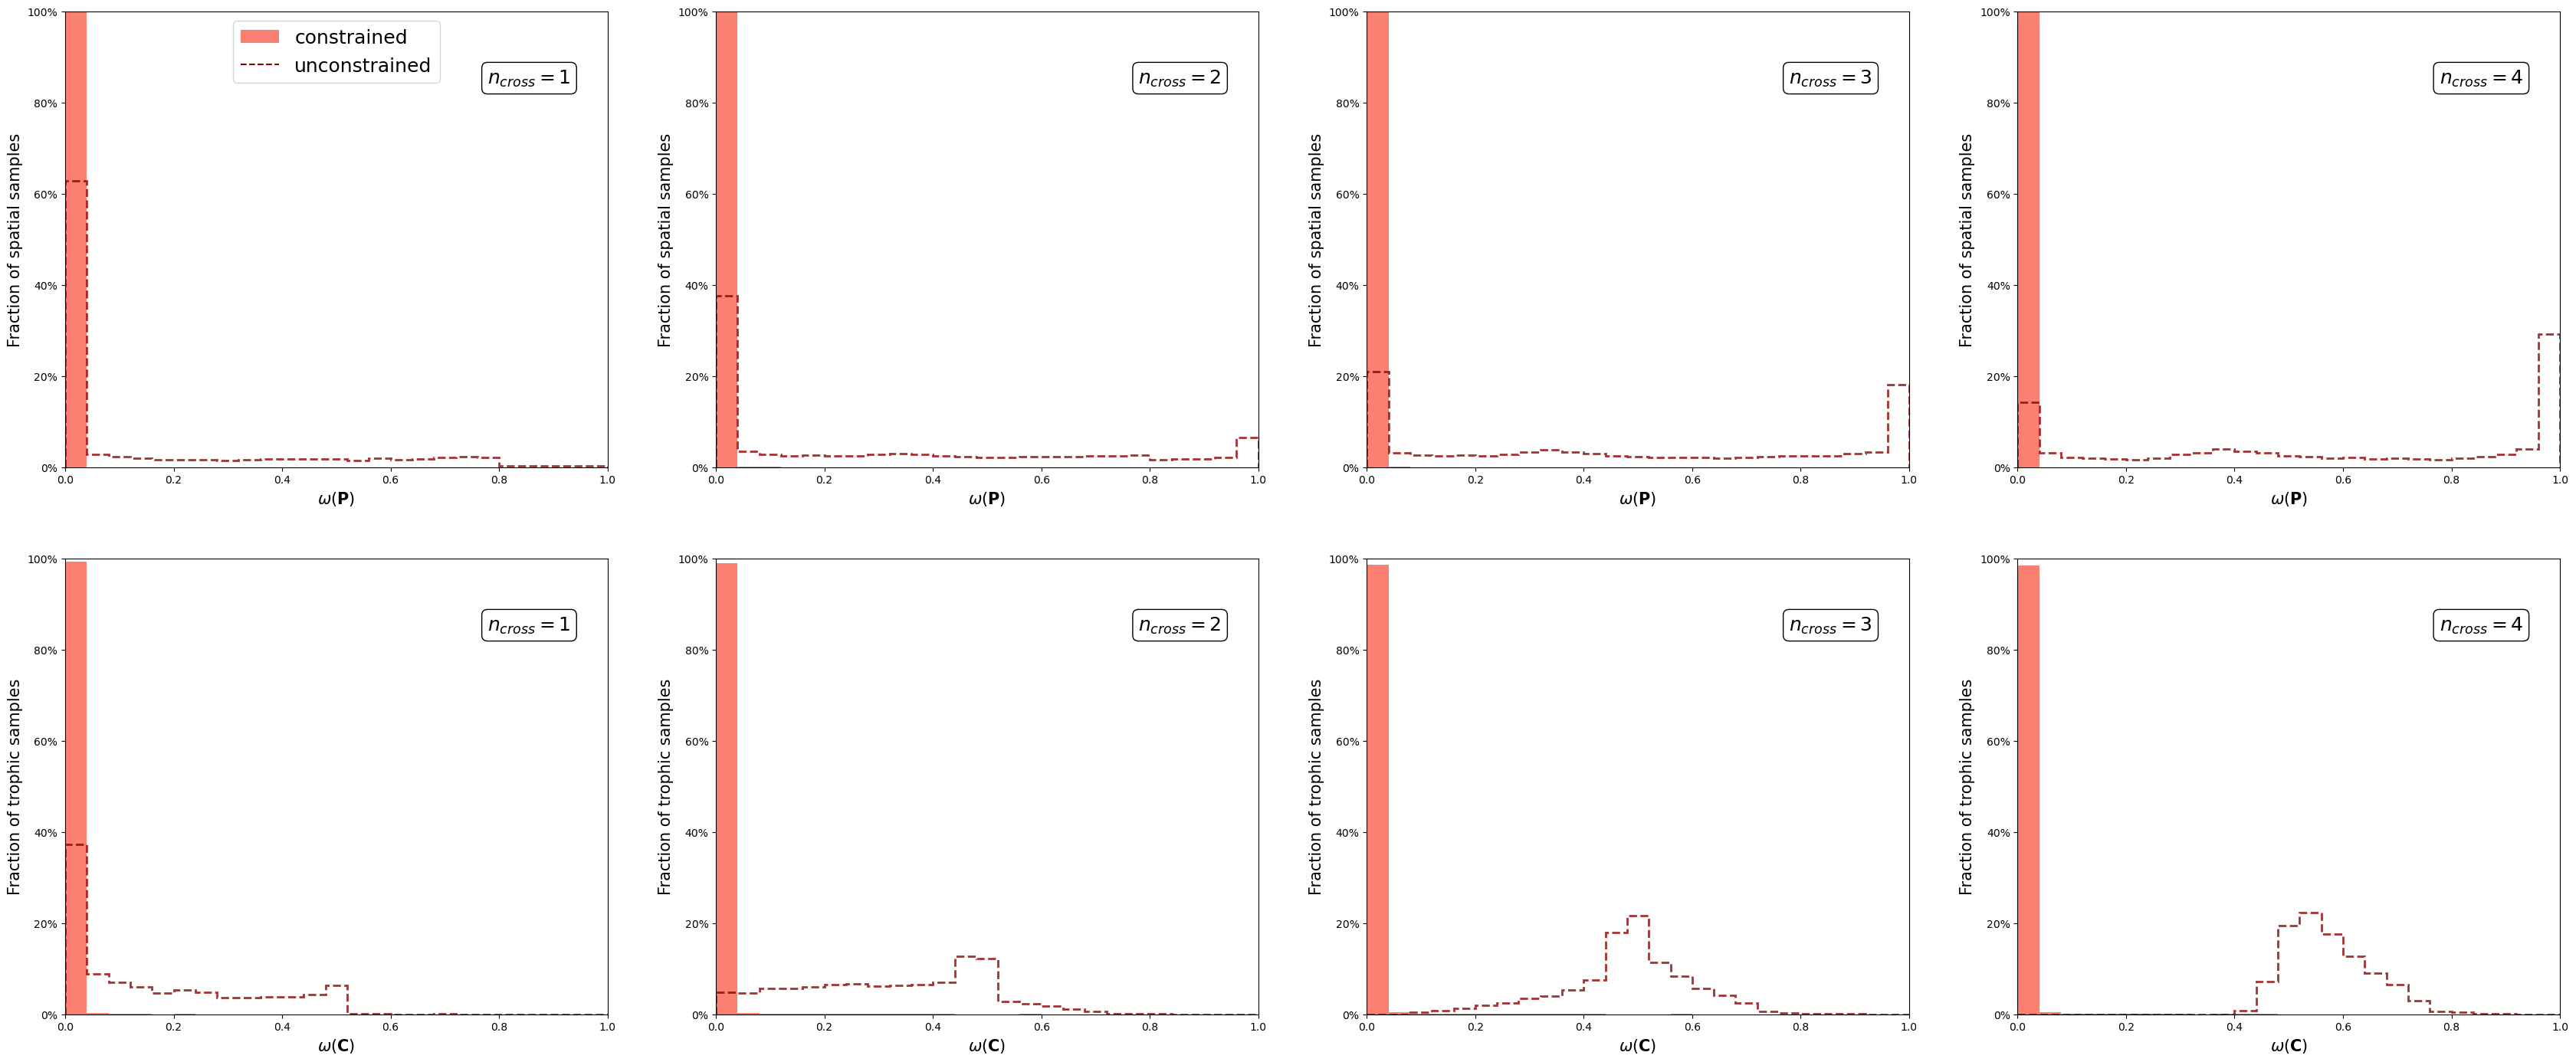

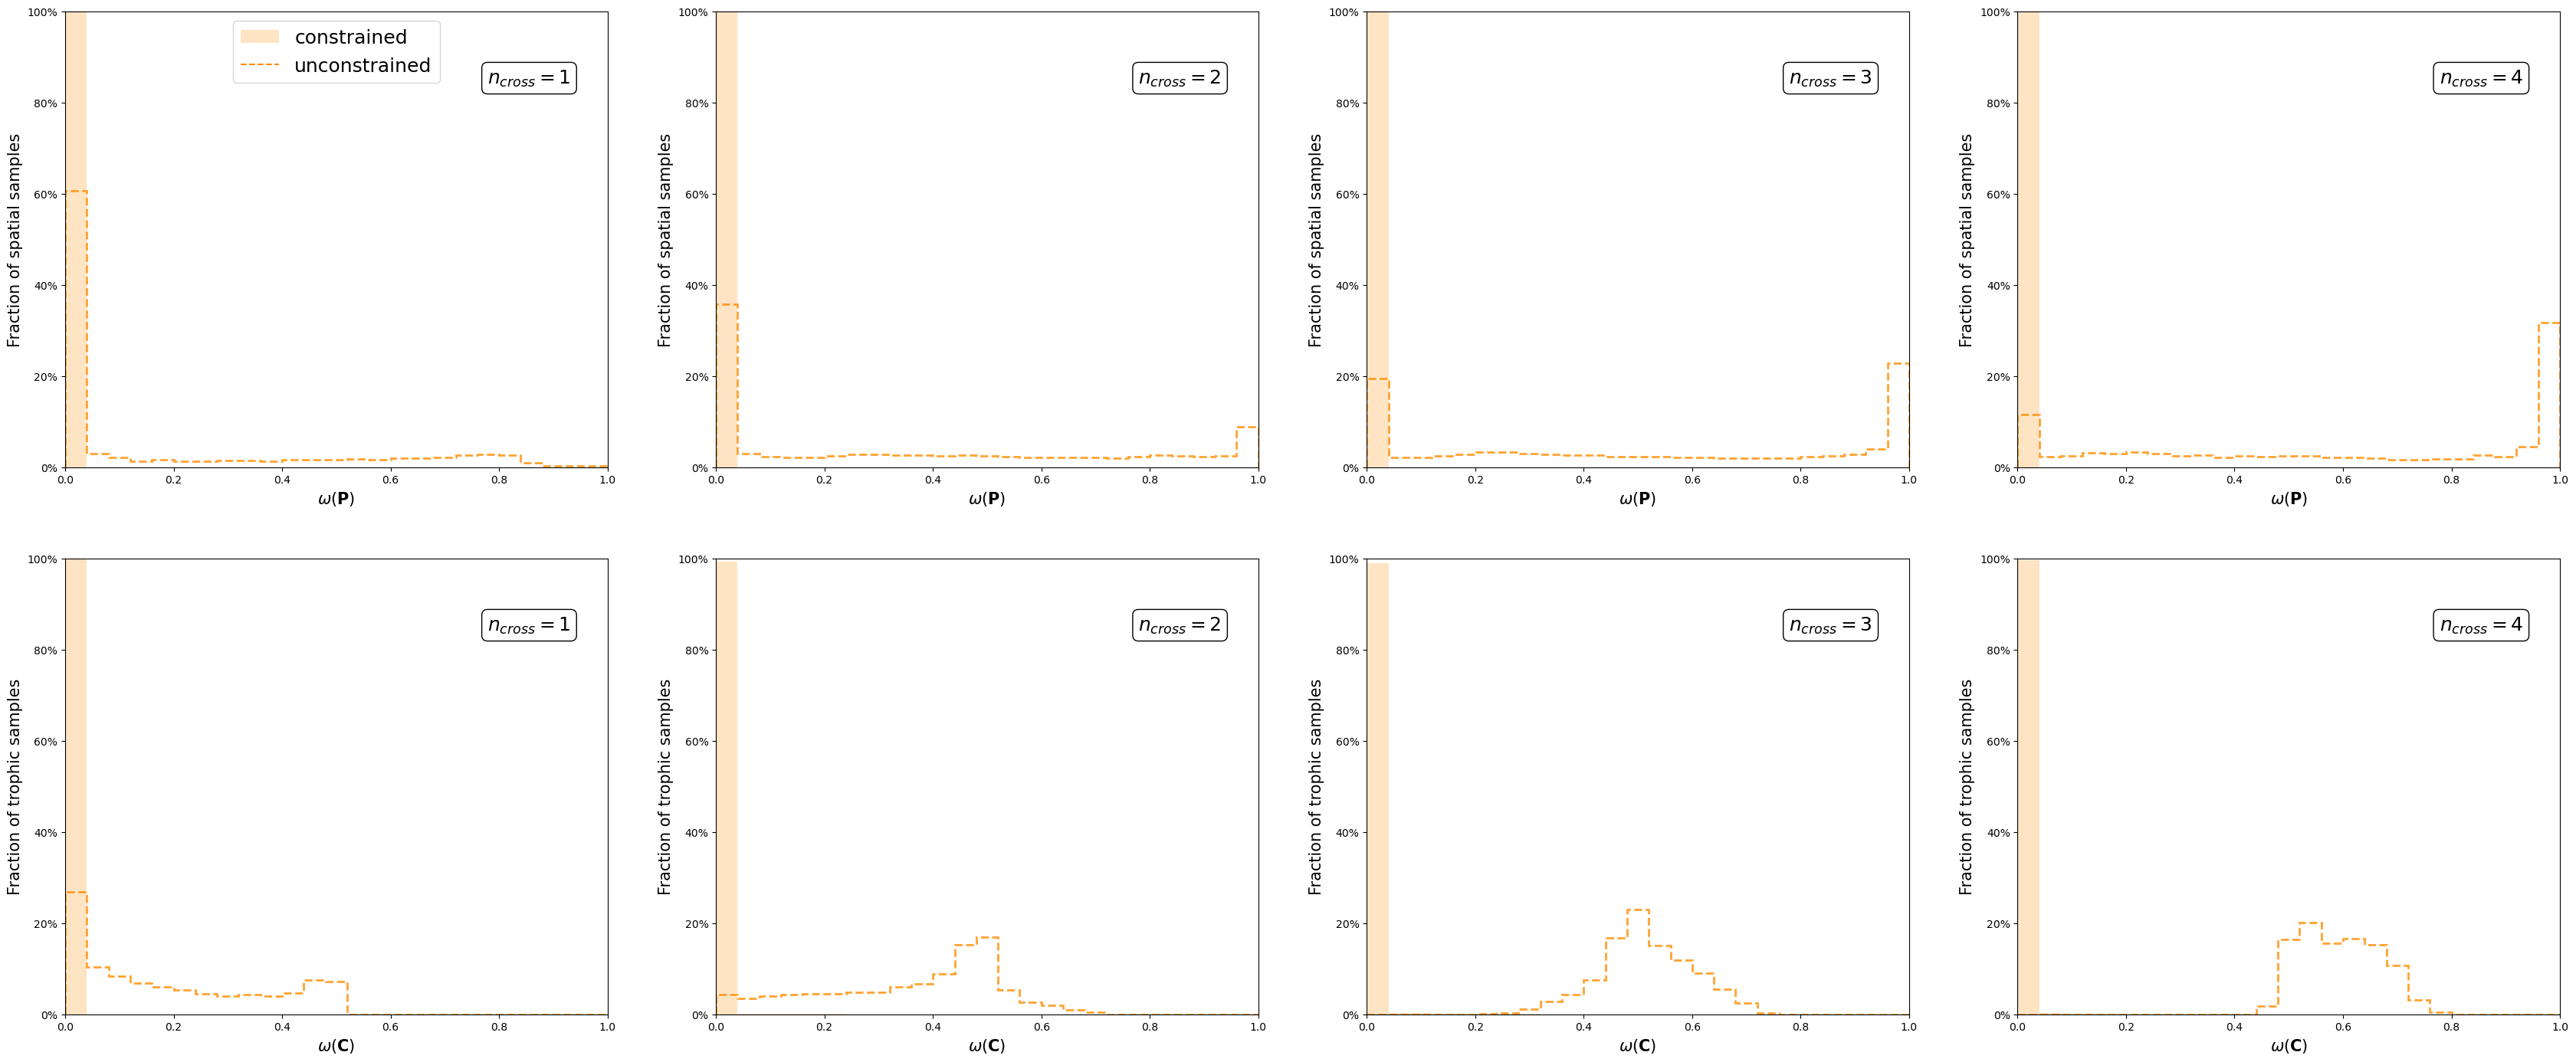

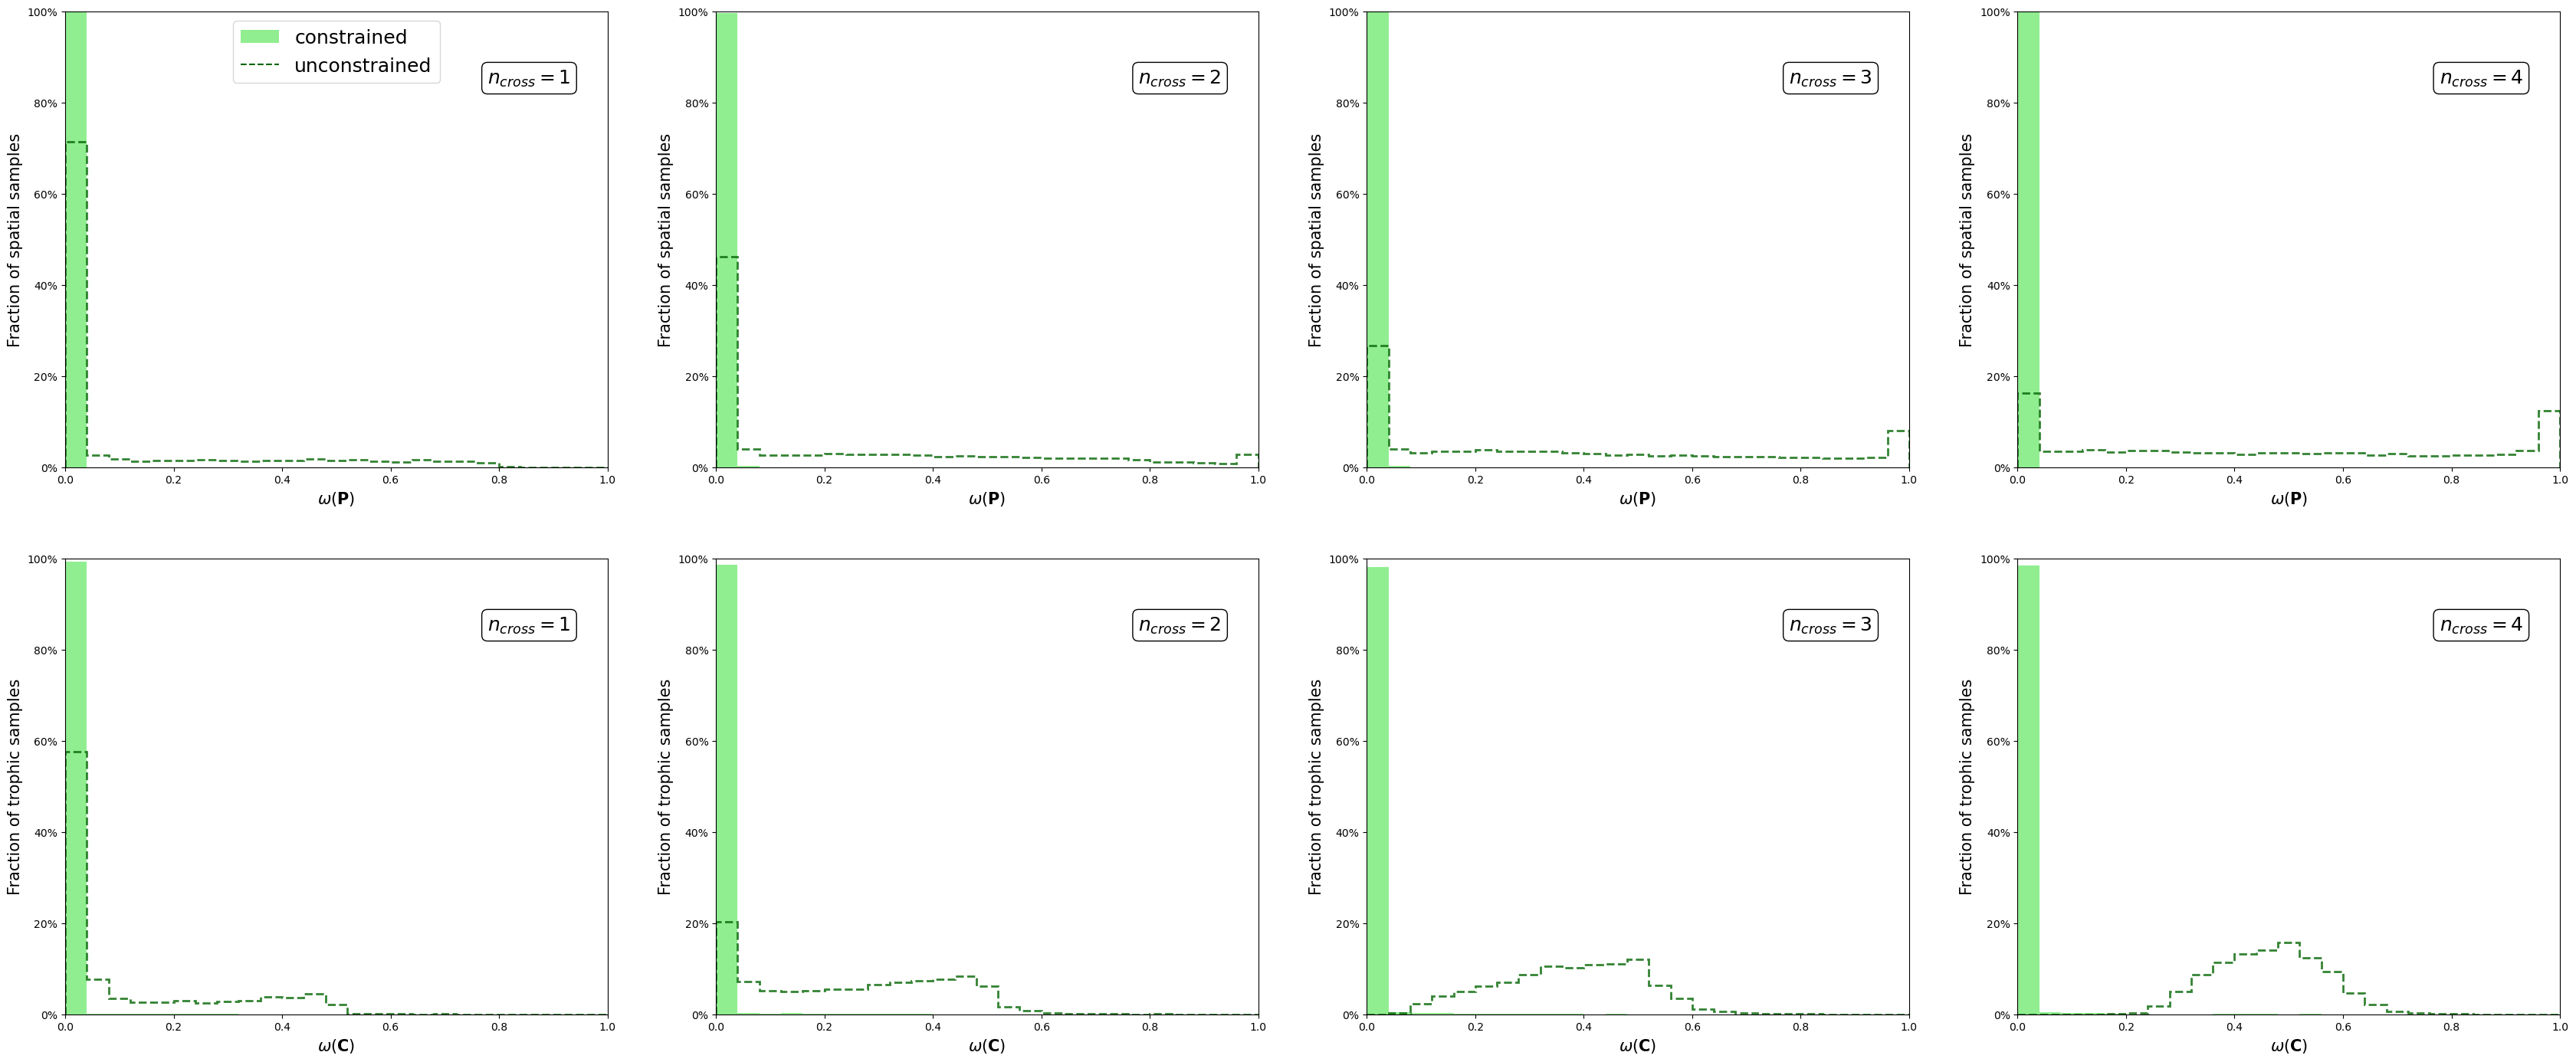

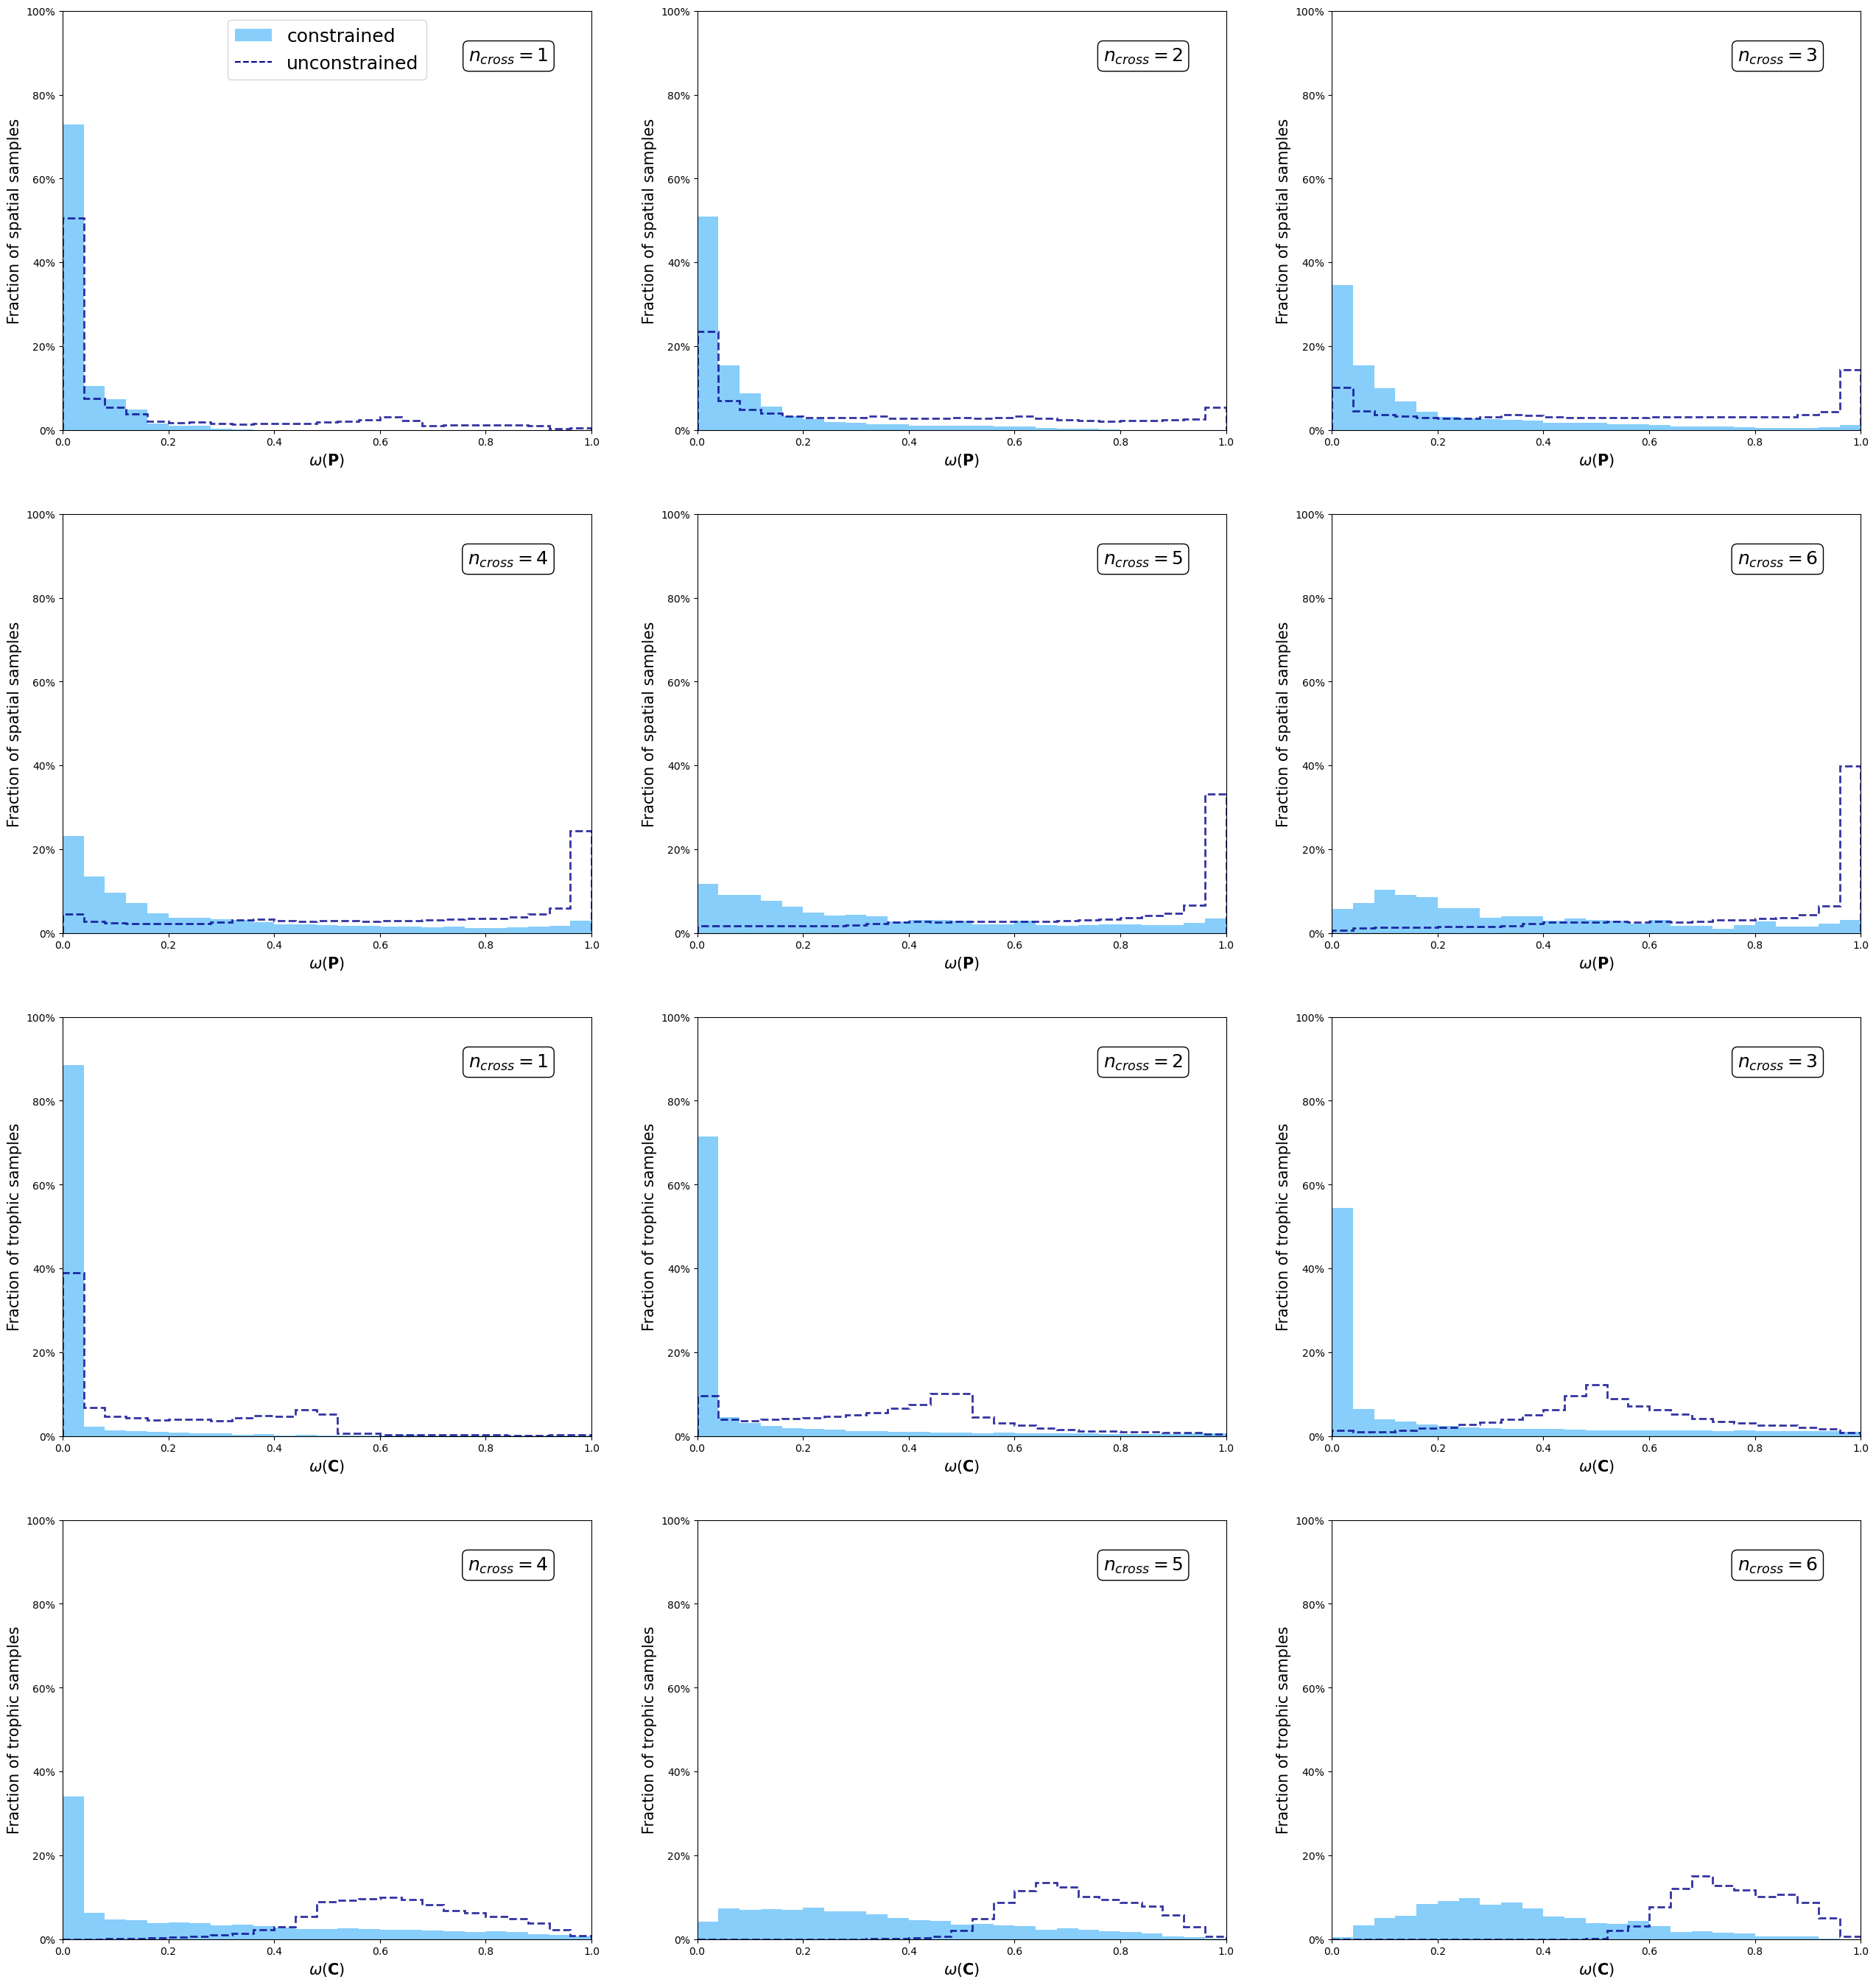

In [4]:
savefig = False
# con_colors = ['red', 'orange', 'green', 'blue']
con_colors = ['salmon', 'bisque', 'lightgreen', 'lightskyblue']
uncon_colors = ['darkred', 'darkorange', 'darkgreen', 'darkblue']
for module_idx, module in enumerate(modules):
    plotall = True
    figpath = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
    figfn = 'robustness_histograms_all_{}.png'.format(module) if plotall else 'robustness_histograms.png'
    rob_keys = ['local', 'spatial']
    if plotall and (module != 'omnivory'):
        plt.figure(figsize=(10.5*4, 8.5*2))
    elif plotall and (module == 'omnivory'):
        plt.figure(figsize=(10.5*3, 8.5*4))
    else:
        plt.figure(figsize=(10.5*2, 8.5*2))
    bins = 25
    axfontsize = 14
    titlefontsize = 16

    n_cross_slice = n_cross_arr[1:] if plotall else [1,6]
    for n_cross in n_cross_slice: 
        if plotall and (module != 'omnivory') and (n_cross >= 5):
            continue
        with sg.H5Store('robustness.h5').open(mode='r') as rob_data:
            for rob_idx, rob_key in enumerate(rob_keys):
                if plotall and (module != 'omnivory'):
                    plt_idx = (n_cross) + (rob_idx*4)
                    ax = plt.subplot(2, 4, int(plt_idx))
                elif plotall and (module == 'omnivory'):
                    plt_idx = (n_cross) + (rob_idx*6)
                    ax = plt.subplot(4, 3, int(plt_idx))
                else:
                    if n_cross == 1:
                        plt_idx = rob_idx * 2 + 1
                    else:
                        plt_idx = rob_idx * 2 + 2
                    ax = plt.subplot(2, 2, int(plt_idx))
                # First plot constrained distribution
                data_key = '{}/robustness/{}/constrained/{}'.format(module,rob_key,str(n_cross))
                data = np.array(rob_data[data_key])
                label = 'constrained' if (n_cross==1) and (rob_idx==0) else ''
                N, bins, patches = ax.hist(data, range=(0,1), bins=bins, 
                                           density=True, histtype='bar', linewidth=2, 
                                           color=con_colors[module_idx], label=label)
                # Now plot unconstrained distribution
                data_key = '{}/robustness/{}/unconstrained/{}'.format(module,rob_key,str(n_cross))
                data = np.array(rob_data[data_key])
                label = 'unconstrained' if (n_cross==1) and (rob_idx==0) else ''
                ax.hist(data, range=(0,1), bins=bins, 
                        density=True, histtype='step', linewidth=2, color=uncon_colors[module_idx], 
                        linestyle='--', alpha=0.8)
                ax.plot([], [], linestyle='--', label=label, color=uncon_colors[module_idx])
                # Set misc plot parameters
                label = r'$n_{{{}}}={{{}}}$'.format('cross',n_cross)
                ax.annotate(label, xy=(475, 375), xycoords='axes points',
                            size=18, ha='right', va='top',
                            bbox=dict(boxstyle='round', fc='w'))
                binsize = bins[1] - bins[0]
                maxN = 1 / binsize
                ax.set_ylim(0, maxN)
                ax.yaxis.set_major_formatter(PercentFormatter(xmax=maxN))
                # ax.semilogx()
                ax.set_xlim(0,1)
                if rob_key == 'local':
                    xlabel = r'$\omega\left(\bf{{{}}}\right)$'.format('P')
                    ylabel = 'Fraction of spatial samples'
                else:
                    xlabel = r'$\omega\left(\bf{{{}}}\right)$'.format('C')
                    ylabel = 'Fraction of trophic samples'
                ax.set_xlabel(xlabel, fontsize=axfontsize+1)
                ax.set_ylabel(ylabel, fontsize=axfontsize+1)
                # ax.set_title(r'$\langle q \rangle=\frac{{{}}}{{6}}$'.format(n_cross), fontsize=titlefontsize)
                # ax.set_title('{} interspecific sensitivity'.format(n_cross), fontsize=axfontsize)
                if (n_cross==1) and (rob_idx==0):
                    ax.legend(loc='upper center', prop={'size': 18})
    if savefig:
        plt.savefig(figpath + figfn, bbox_inches='tight')

KeyError: 'Unable to open object (component not found)'

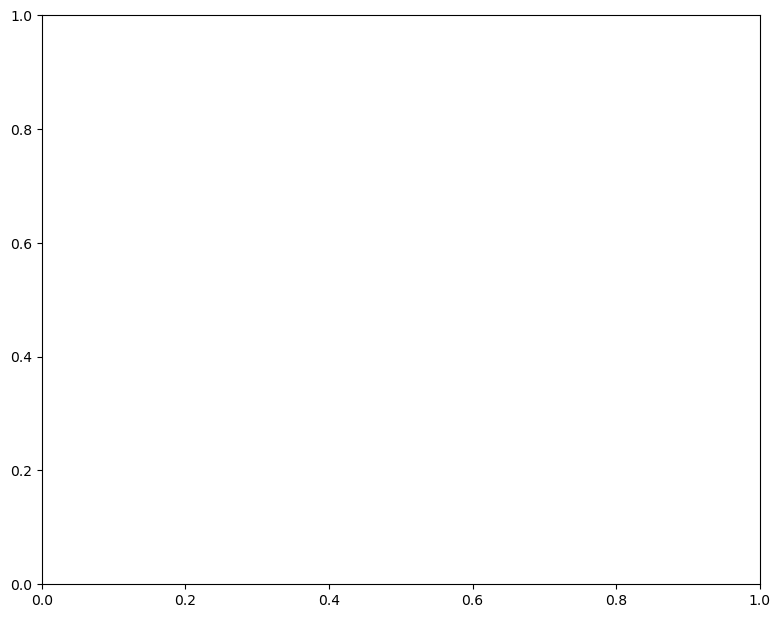

In [12]:
savefig = True
plotall = True
figpath = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
figfn = 'robustness_histograms_all.png' if plotall else 'robustness_histograms.png'
rob_keys = ['local', 'spatial']
if plotall:
    # plt.figure(figsize=(10.5*4, 8.5*4))
    plt.figure(figsize=(10.5*3, 8.5*4))
else:
    plt.figure(figsize=(10.5*2, 8.5*2))
bins = 25
axfontsize = 14
titlefontsize = 16

n_cross_slice = n_cross_arr[1:] if plotall else [1,6]
for n_cross in n_cross_slice: 
    with sg.H5Store('robustness.h5').open(mode='r') as rob_data:
        for rob_idx, rob_key in enumerate(rob_keys):
            if plotall:
                plt_idx = (n_cross) + (rob_idx*6)
                ax = plt.subplot(4, 3, int(plt_idx))
            else:
                if n_cross == 1:
                    plt_idx = rob_idx * 2 + 1
                else:
                    plt_idx = rob_idx * 2 + 2
                ax = plt.subplot(2, 2, int(plt_idx))
            # First plot constrained distribution
            data_key = '{}/{}/{}/{}'.format(str(n_cross),'robustness',rob_key,'constrained')
            data = np.array(rob_data[data_key])
            label = 'constrained' if (n_cross==1) and (rob_idx==0) else ''
            N, bins, patches = ax.hist(data, range=(0,1), bins=bins, 
                                       density=True, histtype='bar', linewidth=2, color='cornflowerblue',
                                       label=label)
            # Now plot unconstrained distribution
            data_key = '{}/{}/{}/{}'.format(str(n_cross),'robustness',rob_key,'unconstrained')
            data = np.array(rob_data[data_key])
            label = 'unconstrained' if (n_cross==1) and (rob_idx==0) else ''
            ax.hist(data, range=(0,1), bins=bins, 
                    density=True, histtype='step', linewidth=2, color='darkblue', 
                    linestyle='--', alpha=0.8)
            ax.plot([], [], linestyle='--', label=label, color='darkblue')
            # # Label the q value of the plot
            # label = r'$\langle q \rangle=\frac{{{}}}{{6}}$'.format(n_cross)
            # ax.plot([], [], linestyle=None, label=label)
            # Set misc plot parameters
            label = r'$\langle q \rangle=\frac{{{}}}{{6}}$'.format(n_cross)
            ax.annotate(label, xy=(475, 375), xycoords='axes points',
                        size=18, ha='right', va='top',
                        bbox=dict(boxstyle='round', fc='w'))
            binsize = bins[1] - bins[0]
            maxN = 1 / binsize
            ax.set_ylim(0, maxN)
            ax.yaxis.set_major_formatter(PercentFormatter(xmax=maxN))
            # ax.semilogx()
            ax.set_xlim(0,1)
            if rob_key == 'local':
                xlabel = r'$\omega\left(\bf{{{}}}\right)$'.format('P')
                ylabel = 'Fraction of spatial samples'
            else:
                xlabel = r'$\omega\left(\bf{{{}}}\right)$'.format('C')
                ylabel = 'Fraction of trophic samples'
            ax.set_xlabel(xlabel, fontsize=axfontsize+1)
            ax.set_ylabel(ylabel, fontsize=axfontsize+1)
            # ax.set_title(r'$\langle q \rangle=\frac{{{}}}{{6}}$'.format(n_cross), fontsize=titlefontsize)
            # ax.set_title('{} interspecific sensitivity'.format(n_cross), fontsize=axfontsize)
            if (n_cross==1) and (rob_idx==0):
                ax.legend(loc='upper center', prop={'size': 18})
if savefig:
    plt.savefig(figpath + figfn, bbox_inches='tight')

## Total robustness

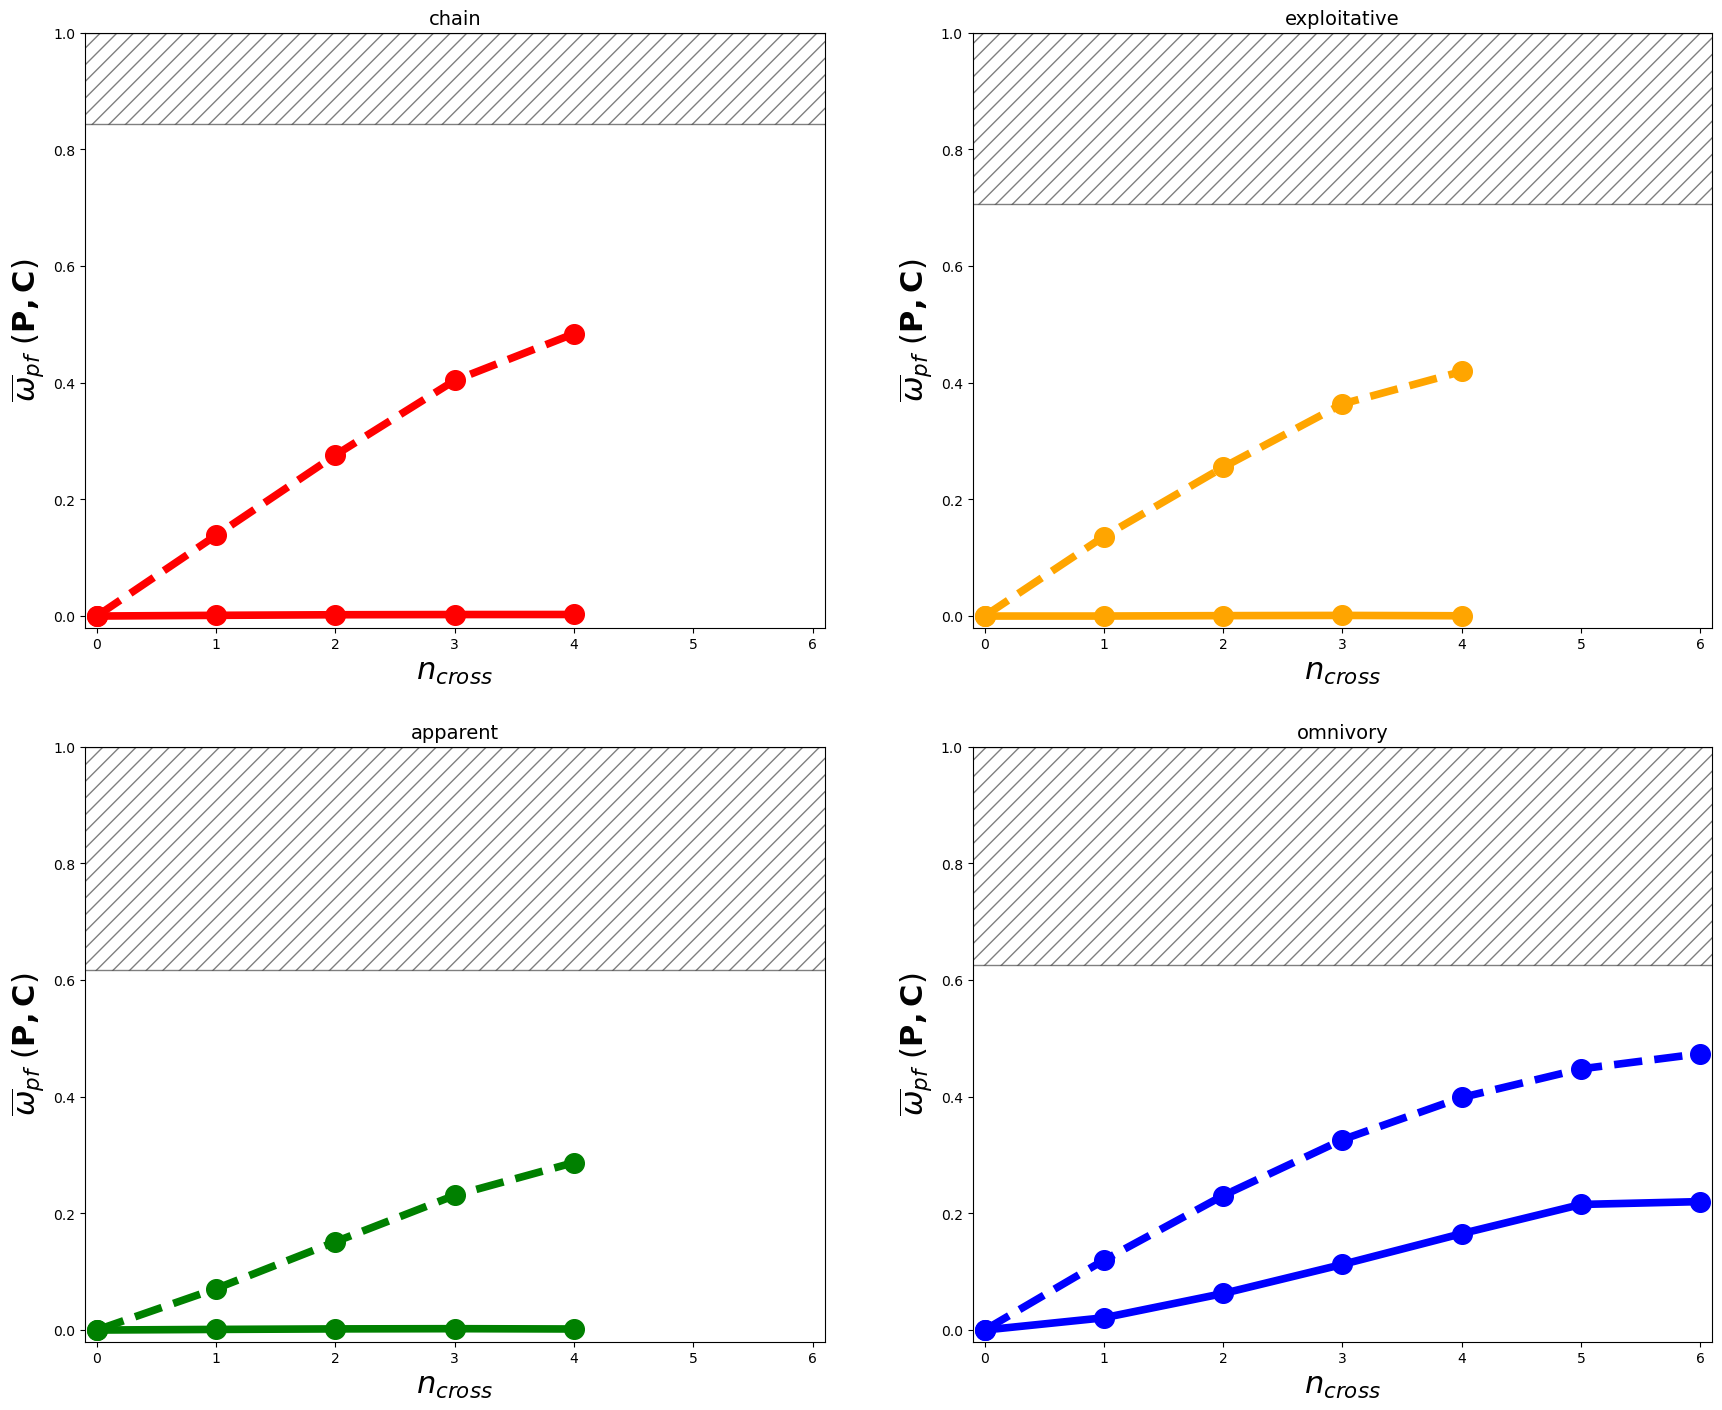

In [28]:
savefig = True
figpath = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
figfn = 'average_omega_per_module_bar.png' 
constraint_keys = ['unconstrained', 'constrained']
axfontsize = 22
num_subplots = len(modules)
markersize = 200
linewidth = 5.5
xmargin = 0.1
ymargin = 0.02
colors = ['red', 'orange', 'green', 'blue']
plt.figure(figsize=(10.5*2, 8.5*2))
with sg.H5Store('robustness.h5').open(mode='r') as rob_data:
    for module_idx, module in enumerate(modules):
        ax = plt.subplot(2, 2, module_idx+1)
        unstable_rob = float(rob_data['{}/robustness/unstable'.format(module)])
        for cons_key in constraint_keys:
            data_key = '{}/robustness/total/{}'.format(module, cons_key)
            '''Dont know if this is right, should update robustness.py'''
            # data = np.array(rob_data[data_key]) * (1-fraction_unstable)
            data = np.array(rob_data[data_key])
            ls = '--' if cons_key == 'unconstrained' else '-'
            ax.plot(n_cross_arr, data, ls=ls, lw=linewidth, color=colors[module_idx])
            ax.scatter(n_cross_arr, data, s=markersize, color=colors[module_idx])
        # ax.set_ylim(-0.01, 1 - unstable_rob)
        ax.set_ylim(0-ymargin, 1)
        # ax.fill_between(np.arange(-1,8), y1=1, y2=1-unstable_rob, color='lightcoral', alpha=0.5)
        ax.fill_between(np.arange(-1,8), y1=1, y2=1-unstable_rob, facecolor='none', alpha=0.5, hatch='//')
        # ax.axhline(1 - unstable_rob, color='red', alpha=0.5)
        # ax.axhline(0.5, alpha=0.5, color='lightgrey')
        ax.set_ylabel(r'$\overline{\omega}_{pf}~\left(\bf{P},\bf{C}\right)$', fontsize=axfontsize)
        ax.set_xlim(0-xmargin, 6+xmargin)
        ax.set_xlabel(r'$n_{cross}$', fontsize=axfontsize)
        ax.set_title(module, fontsize=14)
if savefig:
    plt.savefig(figpath + figfn, bbox_inches='tight')

In [5]:
df = project.to_dataframe(sp_prefix='', doc_prefix='', flatten=True)
model_params = [p for p in list(project.detect_schema()) if 'model_params' in p]
cross_colors = ['mediumblue', 'cornflowerblue', 'green', 'yellowgreen', 'orangered', 'lightcoral']
# Get column labels for data with n_cross nonzero offdiagonal C elements
cross_labels = []
for n_cross in n_cross_arr:
    n_cross_labels = []
    if n_cross == 0:
        cross_combs = [[]]
    else:
        cross_combs = [comb for comb in combinations(C_offdiags, n_cross)]
    for cross_comb in cross_combs:
        # Make label for nonzero offdiagonals to store in job data
        if len(cross_comb) == 0:
            cross_label = 'diag'
        else:
            cross_label = ','.join([str(c[0])+str(c[1]) for c in cross_comb])
        n_cross_labels.append(cross_label)
    cross_labels.append(n_cross_labels)

/Users/patrick/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/patrick/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/jd/fczwycqx1lxch_x4svbjh6680000gn/T/ipykernel_64664/1655089859.py:98: RuntimeWarning: Mean of empty slice
  data[s_key][c_key]['mean'][n_cross_i] = np.nanmean(means)


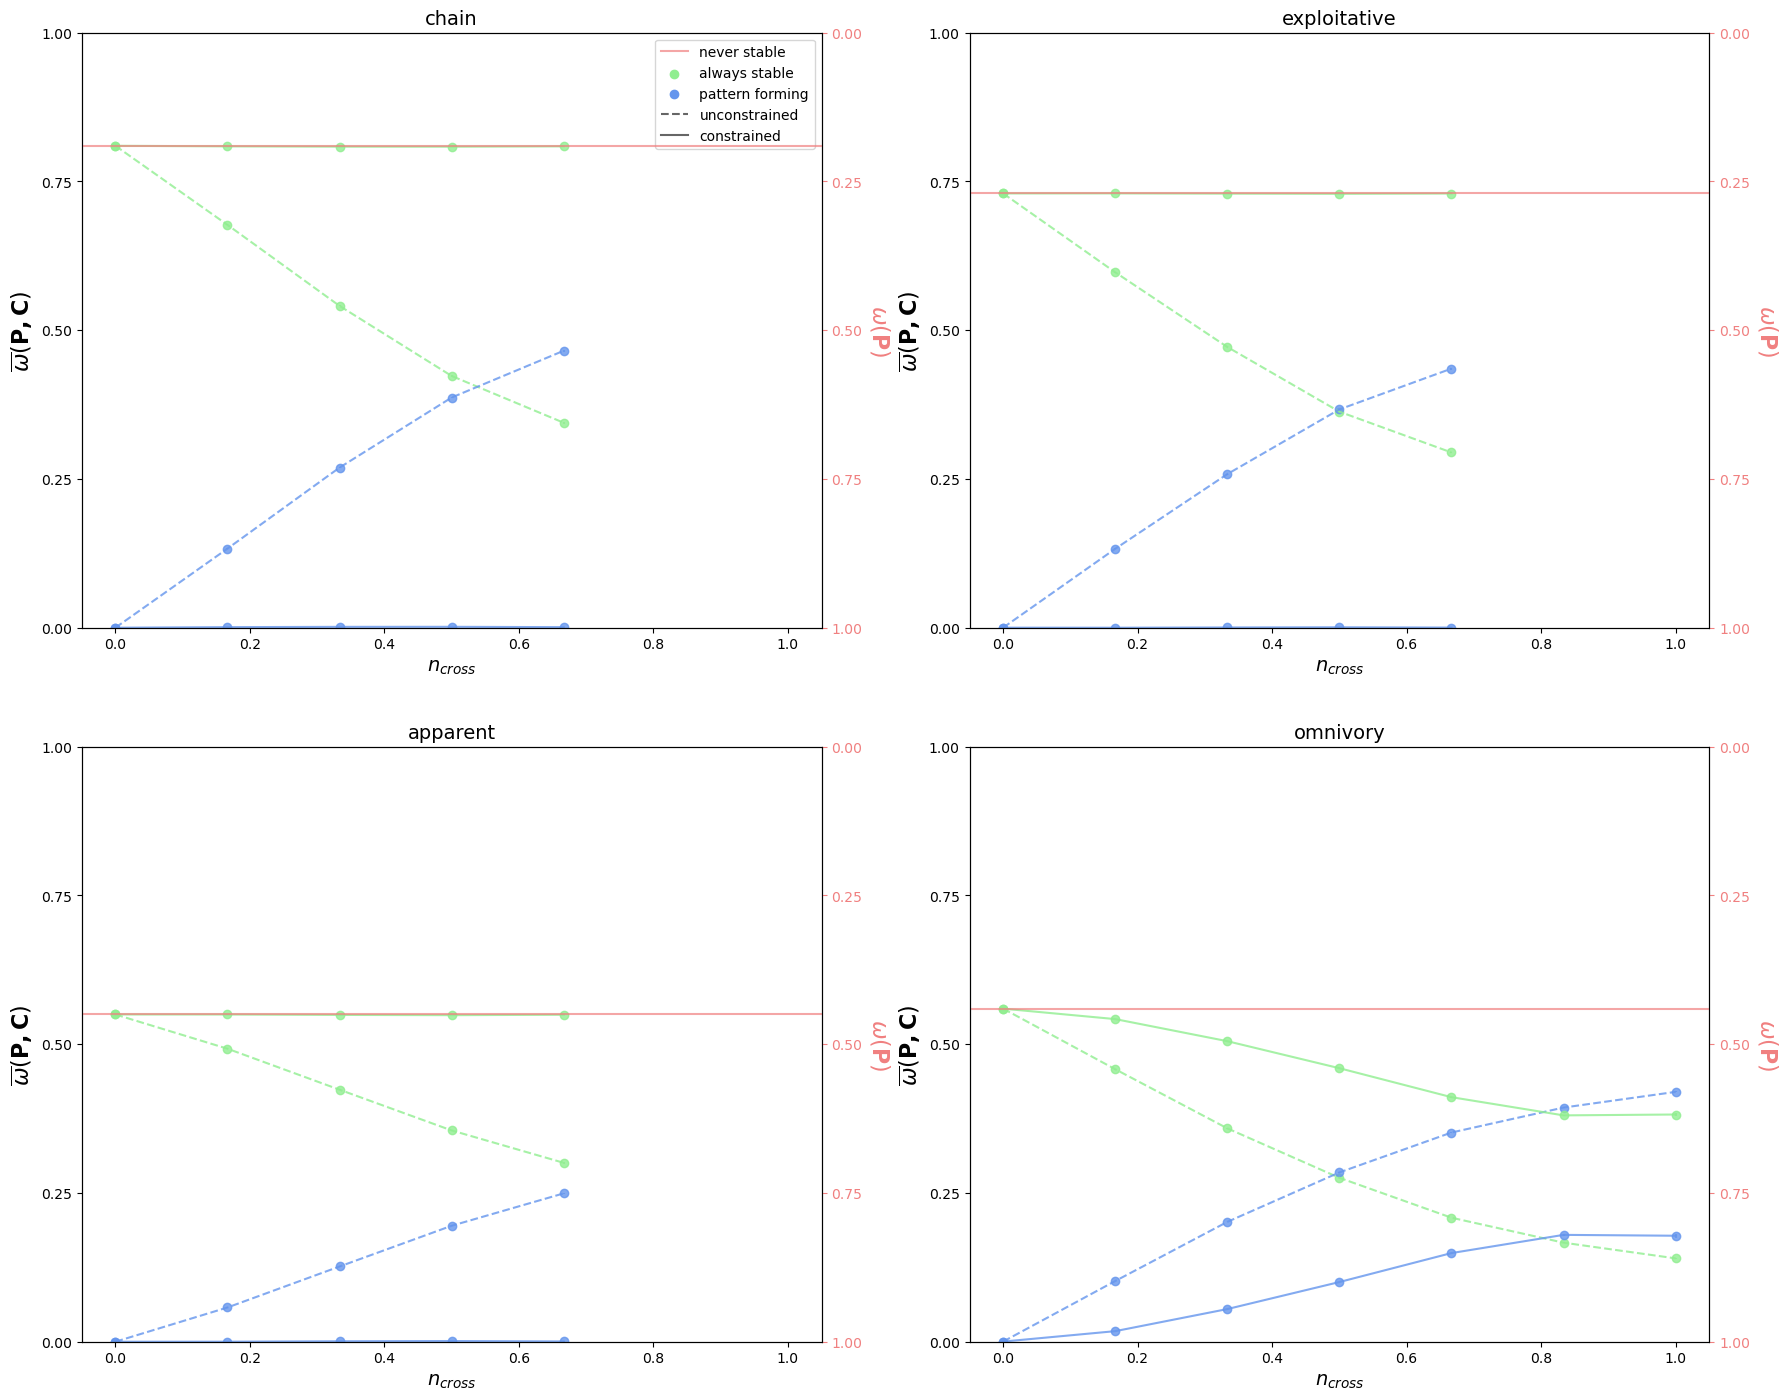

In [6]:
savefig = False
per_module = True
verbose = False
figpath = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
figfn = 'average_omega_per_module.png' if per_module else 'average_omega.png'
colors = ('lightgreen', 'cornflowerblue', 'lightcoral')
alp = 0.8
constraint_keys = ['unconstrained', 'constrained']
stab_keys = ['ddi', 'stab']
axfontsize = 16

# Initialize plotting
if per_module:
    num_subplots = len(modules)
    # plt.figure(figsize=(10.5*num_subplots, 7))
    plt.figure(figsize=(10.5*2, 8.5*2))
else:
    plt.figure(figsize=(9,7))
    ax = plt.subplot()
    num_subplots = 1

for i in range(num_subplots):
# for i in [0]:
    # Initialize data
    data = {}
    for key1 in stab_keys:
        data[key1] = {}
        for key2 in constraint_keys:
            data[key1][key2] = {key3: np.zeros(len(q_expected_arr)) for key3 in ['mean', 'stdev']}
    # Filter for feasible parameterizations in desired module(s)
    if per_module:
        # ax = plt.subplot(1, num_subplots, i+1)
        ax = plt.subplot(2, 2, i+1)
        df_module = df[(df['local_stability'] != 'infeasible') & (df['module'] == modules[i])]
    else:
        df_module = df[df['local_stability'] != 'infeasible']
    # Store fraction of never stable (only depends on parameterizations)
    ns_bool = df_module['local_stability'] == 'unstable'
    ns_mean = sum(ns_bool) / len(df_module)
    data['ns'] = ns_mean
    
    # Get omega, constrained and unconstrained, at each value of q
    for q, n_cross in zip(q_expected_arr, n_cross_arr):
        n_cross_i = np.nonzero(n_cross_arr == n_cross)[0][0]
        if verbose: print('q',q, n_cross)
        if verbose: print('cross scenarios', cross_labels[n_cross_i])
        if verbose: print('never stable', data['ns'])
        for c_key, s_key in product(constraint_keys, stab_keys):
            if verbose: print(c_key, s_key)
            # Get the mean for each cross diffusive scenario with off diagonal probability q
            means = []
            stdevs = []
            for cross_label in cross_labels[n_cross_i]:
                if verbose: print('scenario:', cross_label)
                # Get the column label for this scenario in data
                data_label = 'omega_{}.{}'.format(c_key, cross_label)
                # Get the mean value of omega (ddi and stable) across parameterizations
                if s_key == 'ddi':
                    ddi_arr = np.array(df_module[data_label])
                    ddi_arr = ddi_arr[~np.isnan(ddi_arr)]
                    mean = np.mean(ddi_arr)
                    if verbose: print('omega ddi per parameterization', ddi_arr)
                    means.append(mean)
                    if verbose: print('mean across parameterizations', mean)
                    # Get the standard deviation propagated over nonspatial samples
                    data_label = 'stdev_{}.{}'.format(c_key, cross_label)
                    stdev_arr = np.array(df_module[data_label])
                    stdev_arr = stdev_arr[~np.isnan(stdev_arr)]
                    if not np.isnan(mean):
                        stdev = (1/len(stdev_arr)) * np.sqrt(sum(np.square(stdev_arr)))
                        stdevs.append(stdev)
                elif s_key == 'stab':
                    # If invalid cross scenario (np.nan stored), set omega_stable to nan too
                    if np.all(np.isnan(df_module[data_label])):
                        mean = np.nan
                        if verbose: print('omega stab per parameterization', mean)
                    else:
                        stab_arr = 1.0 - np.array(df_module[data_label])
                        stab_arr = np.where(ns_bool, 0.0, stab_arr)
                        if verbose: print('omega stab per parameterization', stab_arr)
                        mean = np.nanmean(stab_arr)
                        # stdev = (1/len(stab_arr)) * np.sqrt(sum(np.square(stab_arr)))
                        # stdevs.append(stdev)
                        data_label = 'stdev_{}.{}'.format(c_key, cross_label)
                        stdev_arr = np.array(df_module[data_label])
                        stdev_arr = stdev_arr[~np.isnan(stdev_arr)]
                        if not np.isnan(mean):
                            stdev = (1/len(stdev_arr)) * np.sqrt(sum(np.square(stdev_arr)))
                            stdevs.append(stdev)
                    means.append(mean)
                    if verbose: print('mean across parameterizations', mean)
                else:
                    sys.exit('Invalid stability key')
            if verbose: print('mean for each scenario', means)
            if verbose: print('mean across scenarios', np.nanmean(means))
            if verbose: print('---------------------------------')
            # Store the mean over all scenarios
            data[s_key][c_key]['mean'][n_cross_i] = np.nanmean(means)
            # Propagate the error over all scenarios
            if len(stdevs) == 0:
                stdev = np.nan
            else:
                stdev = (1/len(stdevs)) * np.sqrt(sum(np.square(stdevs)))
            data[s_key][c_key]['stdev'][n_cross_i] = stdev
        if verbose: print()
        
    # Plot
    for constraint_key in constraint_keys:
        ls = '--' if constraint_key == 'unconstrained' else '-'
        # ax.plot(q_expected_arr, data['stab'][constraint_key]['mean'], ls=ls, c=colors[0], alpha=alp)
        ax.errorbar(q_expected_arr, data['stab'][constraint_key]['mean'], yerr=data['stab'][constraint_key]['stdev'],
                    ls=ls, c=colors[0], alpha=alp)
        ax.scatter(q_expected_arr, data['stab'][constraint_key]['mean'], c=colors[0], alpha=alp)
        # ax.plot(q_expected_arr, data['ddi'][constraint_key]['mean'], ls=ls, c=colors[1], alpha=alp)
        ax.errorbar(q_expected_arr, data['ddi'][constraint_key]['mean'], yerr=data['ddi'][constraint_key]['stdev'],
                ls=ls, c=colors[1], alpha=alp)
        ax.scatter(q_expected_arr, data['ddi'][constraint_key]['mean'], c=colors[1], alpha=alp)
    # Dummy horizontal line for never stable label, actually plot on 2nd y axis
    ax.axhline(-1, ls='-', color=colors[2], label='never stable', alpha=alp-0.1)
    ax.scatter([], [], c=colors[0], label='always stable')
    ax.scatter([], [], c=colors[1], label='pattern forming')
    ax.plot([], [], ls='--', alpha=0.6, color='black', label='unconstrained')
    ax.plot([], [], alpha=0.6, color='black', label='constrained')
    if (per_module == False) or (per_module and (i==0)):
        ax.legend()
    ax.set_xlabel(r'$n_{cross}$', fontsize=14)
    ax.set_ylabel(r'$\overline{\omega}\left(\bf{P},\bf{C}\right)$', fontsize=axfontsize)
    ax.set_yticks(np.linspace(0,1,5))
    ax.margins(y=0)
    ax.set_xlim(-0.05,1.05)
    ax.set_ylim(0,1)
    # 2nd y axis
    ax_right = ax.twinx()
    ax_right.invert_yaxis()
    # ax_right.margins(y=0.05)
    ax_right.set_yticks(np.linspace(0,1,5))
    ax_right.axhline(ns_mean, ls='-', color=colors[2], label='never stable', alpha=alp-0.1)
    ax_right.set_ylabel(r'$\omega\left(\bf{P}\right)$', fontsize=axfontsize, 
                        color=colors[2], rotation=270)
    ax_right.tick_params(axis='y', colors=colors[2])
    ax_right.yaxis.set_label_coords(1.095,0.5)
    ax_right.set_ylim(1,0)
    if per_module:
        ax.set_title(modules[i], fontsize=14)
    # else:
    #     ax.set_title('specified (randomly parameterized) interaction model', fontsize=14)
# if per_module:
#     plt.suptitle('specified (randomly parameterized) interaction model', fontsize=18)
if savefig:
    plt.savefig(figpath + figfn, bbox_inches='tight')
# # Plot legend separately
# label_params = ax.get_legend_handles_labels() 
# figl, axl = plt.subplots()
# axl.axis(False)
# axl.legend(*label_params, loc="center", prop={"size":25})
# if savefig:
#     figl.savefig(figpath+figfn[:-4]+'_legend.png')

## Parameter sensitivities 

In [ ]:
savefig = False
p_arr = np.arange(11)
step = p_arr[-1] - p_arr[-2]
rows, columns = (model_params, modules)
n_cross_arr = np.arange(1, len(C_offdiags)+1)
legend_sizes = [30,12,10,12,25,25]
for n_cross in n_cross_arr:
    if n_cross == 0:
        cross_combs = [[]]
    else:
        cross_combs = [comb for comb in combinations(C_offdiags, n_cross)]
    
    # Get labels for different cross diffusive scenarios
    cross_labels = []
    for cross_comb in cross_combs:
        '''Do I need to fix this in project.py?'''
        cross_comb = np.array((cross_comb))[:,0]
        cross_label = ','.join([str(c[0])+str(c[1]) for c in cross_comb])
        cross_labels.append(cross_label)
        
    plt.figure(figsize=(8*len(columns), 6*len(rows)))
    for module_i, module in enumerate(modules):
        for p_i, p in enumerate(model_params):
            fig_n = p_i * len(columns) + module_i + 1
            ax = plt.subplot(len(rows), len(columns), fig_n)
            
            # Collect the data for each cross diffusive scenario
            omega_diffs = {cl: [] for cl in cross_labels}
            for pv_i in range(len(p_arr)-1):
                df_sub = df[(df['module'] == module) & (df[p] >= p_arr[pv_i]) & (df[p] < p_arr[pv_i+1])]
                for cl in cross_labels:
                    omega_con_avg = df_sub['omega_constrained.'+cl].mean()
                    omega_uncon_avg = df_sub['omega_unconstrained.'+cl].mean()
                    omega_diffs[cl].append(omega_con_avg - omega_uncon_avg)
                    
            # Plot each scenario
            for cross_i, cl in enumerate(cross_labels):
                label = [r'C_{{{}{}}}'.format(spec_labels[int(ij[0])], spec_labels[int(ij[1])]) for ij in cl.split(',')]
                label = r'$' + ','.join(label) + ' \\neq 0$'
                ax.scatter(p_arr[:-1] + step/2, omega_diffs[cl])
                ax.plot(p_arr[:-1] + step/2, omega_diffs[cl], label=label)
            ax.set_xlabel(p.replace('model_params.', ''), fontsize=14)
            # ax.set_ylabel(r'$\omega_{constrained} - \omega_{unconstrained}$', fontsize=14)
            if p_i == 0:
                ax.set_title(module, fontsize=20)
        #     break
        # break
    if savefig:
        path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
        fn='omega_diff_params_cross{}.png'.format(n_cross)
        plt.savefig(path + fn, bbox_inches='tight')
        
    # Plot legend separately
    label_params = ax.get_legend_handles_labels() 
    figl, axl = plt.subplots()
    size_i = np.nonzero(n_cross_arr == n_cross)[0][0]
    axl.axis(False)
    axl.legend(*label_params, loc="center", bbox_to_anchor=(0.5, 0.5), 
               prop={"size":legend_sizes[size_i]})
    if savefig:
        path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
        fn='omega_diff_legend_ncross{}.png'.format(n_cross)
        figl.savefig(path+fn)

## Pulling examples out

In [ ]:
C_ij_idx = 3
C_ij = C_offdiags[C_ij_idx][0]
outfn = 'nonzero_C{}{}_destabilization.csv'.format(spec_labels[C_ij[0]], spec_labels[C_ij[1]])
ascending = False # To sort from most destabilizing to most stabilizing 
df_sub = df[cross_matches[C_ij_idx] & (df['module'] == 'chain')].copy()
df_sub.sort_values(by='con_minus_uncon', ascending=ascending, inplace=True)
df_sub.drop(labels=['surface_generated', 'data_processed', 'param_i', 'N_n'], axis=1, inplace=True)
C_ijs = np.array([list(C_ijs[0]) for C_ijs in df_sub['C_ijs']])
df_sub.insert(1, 'C_offdiag_i', C_ijs[:,0])
df_sub.insert(2, 'C_offdiag_j', C_ijs[:,1])
x0s = np.array([list(x0) for x0 in df_sub['x0']])
df_sub.insert(4, 'steady_state_u', x0s[:,0])
df_sub.insert(5, 'steady_state_v', x0s[:,1])
df_sub.insert(6, 'steady_state_w', x0s[:,2])
df_sub.drop(labels=['C_ijs', 'x0', 'con_minus_uncon'], axis=1, inplace=True)
new_cols = [col.replace('model_params.', '') for col in list(df_sub.columns)]
df_sub.columns = new_cols

In [ ]:
st_coords, wav_coords, stab_coords = ([], [], [])
for row_i, jobid in enumerate(df_sub.index):
    job = project.open_job(id=jobid)
    with job.data:
        st = np.array(job.data['omega_integrand']['st'])
        wav = np.array(job.data['omega_integrand']['wav'])
        stab = np.array(job.data['omega_integrand']['stab'])
        phi_1 = np.array(job.data['phi_1'])
        phi_2 = np.array(job.data['phi_2'])
        phi_3 = np.array(job.data['phi_3'])
        ang_coord_samples = np.hstack((phi_1.reshape((len(phi_1), 1)), 
                                       phi_2.reshape((len(phi_2), 1)), 
                                       phi_3.reshape((len(phi_3), 1))))
        cart_coord_samples = []
        for ang_coord_sample in ang_coord_samples:
            cart_coord_samples.append(spherical_to_cartesian(ang_coord_sample))
        cart_coord_samples = np.array(cart_coord_samples)
        # Select samples where diagonal C elements are similar
        # mean, dev = (0.5, 0.2)
        # cond = (cart_coord_samples[:,1] > mean - dev) & (cart_coord_samples[:,1] < mean + dev) & (cart_coord_samples[:,2] > mean - dev) & (cart_coord_samples[:,2] < mean + dev) & (cart_coord_samples[:,3] > mean - dev) & (cart_coord_samples[:,3] < mean + dev)
    try:
        st_coords.append(cart_coord_samples[st][0])
    except:
        st_coords.append([np.nan for i in range(3)])
    try:
        wav_coords.append(cart_coord_samples[wav][0])
    except:
        wav_coords.append([np.nan for i in range(3)])
    try:
        stab_coords.append(cart_coord_samples[stab][0])
    except:
        stab_coords.append([np.nan for i in range(3)])
st_coords = np.array(st_coords)
wav_coords = np.array(wav_coords)
stab_coords = np.array(stab_coords)
df_sub['stat_ddi_C{}{}'.format(spec_labels[C_ij[0]], spec_labels[C_ij[1]])] = st_coords[:,0]
df_sub['stat_ddi_Cuu'] = st_coords[:,1]
df_sub['stat_ddi_Cvv'] = st_coords[:,2]
df_sub['stat_ddi_Cww'] = st_coords[:,3]
df_sub['stable_C{}{}'.format(spec_labels[C_ij[0]], spec_labels[C_ij[1]])] = stab_coords[:,0]
df_sub['stable_Cuu'] = stab_coords[:,1]
df_sub['stable_Cvv'] = stab_coords[:,2]
df_sub['stable_Cww'] = stab_coords[:,3]
df_sub.reset_index(drop=True, inplace=True)
df_sub.to_csv(outfn)

In [ ]:
import pandas as pd
df_test = pd.read_csv(outfn)
df_test

# Single parameterization

## Define functions

### Read in data

In [ ]:
def init_data(param_i):
    # Organize data into a dict with top key level of modules
    data = {}
    subkeys = ['nocross_omega', 'nocross_omega_sec_mat', 'omega_mat', 'omega_sec_mats']
    for module in modules:
        data.update({module: {}})
    for module_i, module in enumerate(modules):
        omega_mat = np.zeros((3,3))
        omega_sec_mats = []

        for C_offdiag in [[]] + C_offdiags:
            # Find and open the raw data
            for job in project.find_jobs({'module': module, 'C_ijs': C_offdiag, 'param_i': param_i}):
                with job.data:
                    if C_offdiag == []:
                        omega_sum = 0.0
                        omega_sec_mat = np.zeros((2,4))
                        # Loop over parameter space sections
                        for phi_lims in product(range(2), range(4)):
                            conds = []
                            for lim_i, lim in enumerate(phi_lims):
                                conds.append(np.array(job.data['phi_'+str(lim_i+1)]) > lim*np.pi/2)
                                conds.append(np.array(job.data['phi_'+str(lim_i+1)]) < (lim + 1)*np.pi/2)
                            cond = np.all(conds, axis=0)
                            omega_integrand_sec = np.array(job.data['omega_integrand/wav'])[cond] + np.array(job.data['omega_integrand/st'])[cond]
                            i, j = phi_lims
                            omega_sec_mat[i, j] = sum(omega_integrand_sec) / sum(cond)
                            omega_sum += sum(omega_integrand_sec)
                        omega = omega_sum / len(job.data['phi_1'])
                        data[module].update({'nocross_omega': omega})
                        data[module].update({'nocross_omega_sec_mat': omega_sec_mat})
                    else: 
                        omega_sum = 0.0
                        omega_sec_mat = np.zeros((2,2,4))
                        # Loop over parameter space sections 
                        for phi_lims in product(range(2), range(2), range(4)):
                            conds = []
                            for lim_i, lim in enumerate(phi_lims):
                                conds.append(np.array(job.data['phi_'+str(lim_i+1)]) > lim*np.pi/2)
                                conds.append(np.array(job.data['phi_'+str(lim_i+1)]) < (lim + 1)*np.pi/2)
                            cond = np.all(conds, axis=0)
                            omega_integrand_sec = np.array(job.data['omega_integrand/wav'])[cond] + np.array(job.data['omega_integrand/st'])[cond]
                            i, j, k = phi_lims
                            omega_sec_mat[i, j, k] = sum(omega_integrand_sec) / sum(cond)
                            omega_sum += sum(omega_integrand_sec)
                        omega_sec_mats.append(omega_sec_mat)
                        i, j = job.sp['C_ijs'][0]
                        omega_mat[i, j] = (omega_sum / len(job.data['phi_1'])) 
                        data[module].update({'omega_mat': omega_mat})
        data[module].update({'omega_sec_mats': omega_sec_mats})
    return data

### Plotting

In [ ]:
def heatmap(data, row_labels, col_labels, ax, fig,
            xlabel="", ylabel="", title="", cbarlabel="", 
            savefig=False, fn='', path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/',
            **kwargs):
    im = ax.imshow(data, **kwargs)
    cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.8)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, fontsize=15, labelpad=20)
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(col_labels, fontsize=12)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(row_labels, fontsize=12)
    ax.spines[:].set_visible(False)
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_title(title, fontsize=20)
    if savefig:
        if fn == '':
            fn = str(int(np.random.sample()*1e5))+'.png'
        fig.savefig(path + fn)

def heatmap_sub(data, row_labels, col_labels, ax,
            xlabel="", ylabel="", title="", cbarlabel="", 
            axt=False, xtlabels=[], xtlabel="", **kwargs):
    im = ax.imshow(data, **kwargs)
    cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.8)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, fontsize=20, labelpad=20)
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(col_labels, fontsize=12)
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(row_labels, fontsize=12)
    ax.spines[:].set_visible(False)
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_xlabel(xlabel, fontsize=20)
    if axt:
        ax_t = ax.secondary_xaxis('top')
        ax_t.set_xticks(np.arange(data.shape[1]))
        ax_t.set_xticklabels(xtlabels, fontsize=12)
        ax_t.set_xlabel(xtlabel, fontsize=20)
    if title != "":
        ax.set_title(title, fontsize=20)

## Initialize data

In [ ]:
data = init_data(1)

## omega C_ij

In [ ]:
savefig = False
plt.figure( figsize=(6*len(modules), 5*2) )
xticks = ['r','n','p']
yticks = ['r','n','p']
for module_i, module in enumerate(modules):
    nocross_omega = data[module]['nocross_omega']
    omega_mat = data[module]['omega_mat']
    n = module_i + 1
    ax = plt.subplot(2, len(modules), n)
    norm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1.)
    heatmap_sub(omega_mat, yticks, xticks, ax=ax, 
                cbarlabel=r"$\omega_{ddi}$", cmap="Blues", norm=norm,
                title="{}".format(module))
    n = len(modules) + module_i + 1
    ax = plt.subplot(2, len(modules), n)
    omega_diff_mat = omega_mat - nocross_omega*(-1.*(np.eye(3)-1))
    bound = 0.275
    norm = colors.TwoSlopeNorm(vmin=-bound, vcenter=0, vmax=bound)
    heatmap_sub(omega_diff_mat, yticks, xticks, ax=ax, 
                cbarlabel=r"$\Delta\omega_{ddi}$", cmap="RdBu", norm=norm)
                # title="Delta omega {}".format(module))

if savefig:
    path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
    fn='omega_Cij.png'
    plt.savefig(path + fn, bbox_inches='tight')

## omega per section

In [ ]:
savefig = False
from matplotlib import cm, colors
plt.figure( figsize=(10*len(modules), 5*(len(C_offdiags) + 1)) )
xticks = ['C22<0','C22>0','C22>0','C22<0']
xtticks = ['C33<0', 'C33<0', 'C33>0', 'C33>0']
yticks = ['C11<0','C11>0']
for module_i, module in enumerate(modules):
    nocross_omega_sec_mat = data[module]['nocross_omega_sec_mat']
    omega_sec_mats = data[module]['omega_sec_mats']
    n = module_i + 1
    ax = plt.subplot(len(C_offdiags)+1, len(modules), n)
    norm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1.)
    cmap = 'Blues'
    heatmap_sub(nocross_omega_sec_mat, yticks, xticks, ax=ax, axt=True, xtlabels=xtticks,
            cbarlabel=r"$\omega_{dii}$", cmap="Blues", norm=norm,
            title="{} module\nno cross-diffusion".format(module))

    # for i in range(len(C_offdiags)):
    for C_offdiag_i, C_offdiag in enumerate(C_offdiags):
        C_offdiag = C_offdiag[0]
        mean_omega_sec_mat = np.mean(omega_sec_mats[C_offdiag_i], axis=0)
        norm = colors.TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1.)
        cmap = 'Blues'
        # Cij = "C{}{}".format(str(C_offdiags[i][0]+1), str(C_offdiags[i][1]+1))
        i, j = C_offdiag
        n = (C_offdiag_i + 1)*len(modules) + module_i + 1
        ax = plt.subplot(len(C_offdiags)+1, len(modules), n)
        heatmap_sub(mean_omega_sec_mat, yticks, xticks, ax=ax, 
                    axt=True, xtlabels=xtticks,
                    cbarlabel=r"$\omega_{dii}$", cmap="Blues", norm=norm, 
                    title=r'$C_{{{}{}}} \neq 0$'.format(spec_labels[i], spec_labels[j]))

if savefig:
    path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
    fn='omega_sec.png'
    plt.savefig(path + fn, bbox_inches='tight')

## Phase

In [ ]:
for param_i in np.arange(2,3):
    savefig = False
    # param_i = 100
    figpath = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
    figfn = 'phase_nocross_{}.png'.format(param_i)
    path = project.path.split('/')[:-1]
    plt.figure( figsize=(10*len(modules), 5) )
    for module_i, module in enumerate(modules):
        n = module_i + 1
        ax = plt.subplot(1, len(modules), n)
        for job in project.find_jobs({'module': module, 'C_ijs': [], 'param_i': int(param_i)}):
            print(job.id)
            with job.data as nocross_data:
                st = np.array(nocross_data['omega_integrand/st'])
                wav = np.array(nocross_data['omega_integrand/wav'])
                stab = np.array(nocross_data['omega_integrand/stab'])
                xs = np.array(nocross_data['phi_2'])
                ys = np.array(nocross_data['phi_1'])
            colors = []
            for i in range(len(st)):
                if st[i]: colors.append('cornflowerblue')
                elif wav[i]: colors.append('lightcoral')
                # elif wav[i]: colors.append('cornflowerblue')
                elif stab[i]: colors.append('lightgrey')
            lw = 3
            ls = '-'
            c ='black'
            alpha = 0.7
            ax_label_fontsize = 15
            xticks, yticks = ([0.], [0.])
            for phi_lims in product(range(2), range(4)):
                x = (phi_lims[1]+1)*np.pi/2
                xticks.append(x)
                y = (phi_lims[0]+1)*np.pi/2
                yticks.append(y)
                ax.axvline(x, c=c, linewidth=lw, ls=ls, alpha=alpha)
                ax.axhline(y, c=c, linewidth=lw, ls=ls, alpha=alpha)
            xticks = np.unique(xticks)
            yticks = np.unique(yticks)
            ax.scatter(xs, ys, c=colors)
            ax.set_title('{} module'.format(module), fontsize=15)
            ax.set_ylabel(r'$C_{uu}$', fontsize=ax_label_fontsize)
            ax.set_xlim(0,x)
            ax.set_ylim(0,y)
            ax.invert_yaxis()
            ax.set_yticks(yticks)
            ylabels = ['-1', '0', '1']
            ax.set_yticklabels(ylabels)
            ax.set_xticks(xticks)
            xblabels = ['-1', '0', '1', '0', '-1']
            ax.set_xticklabels(xblabels)
            ax.set_xlabel(r'$C_{vv}$', fontsize=ax_label_fontsize)
            ax_t = ax.secondary_xaxis('top')
            xtlabels = ['0', '-1', '0', '1', '0']
            ax_t.set_xticks(xticks)
            ax_t.set_xticklabels(xtlabels)
            ax_t.set_xlabel(r'$C_{ww}$', fontsize=ax_label_fontsize)

    if savefig:
        plt.savefig(figpath + figfn, bbox_inches='tight')

## Positive diagonal, constrained off-diagonal

In [ ]:
for param_i in np.arange(1,21):
    savefig = False
    plt.figure(figsize=(7*len(modules), 5))
    plt.suptitle('intraspecific dispersal > 0\ninterspecific dispersal constrained to opposite sign from interaction ', fontsize=15)
    for module_i, module in enumerate(modules):
        ax = plt.subplot(1, len(modules), module_i + 1)
        omega_con_arr = []
        omega_uncon_arr = []
        'Only include positive diagonal elements, sign of cross diffusion depends on interactions'
        for C_offdiag in [[]] + C_offdiags:
            for job in project.find_jobs({'module': module, 'C_ijs': C_offdiag, 'param_i': int(param_i)}):
                if C_offdiag == []:
                    with job.data:
                        nocross_omega_sec_mat = np.array(job.data['omega_sec_mat'])
                else:
                    omega_con_arr.append(job.doc['omega_constrained'])
                    omega_uncon_arr.append(job.doc['omega_unconstrained'])
                    # print(job.doc.omega_constrained)
                    # import sys; sys.exit()
        xs = range(len(omega_con_arr))
        ax.stem(xs, omega_uncon_arr, bottom=nocross_omega_sec_mat[1,2], basefmt='black', 
                linefmt='blueviolet')
        ax.scatter([],[],color='blueviolet', label=r'$C_{ij}$ unconstrained')
        ax.stem(xs, omega_con_arr, bottom=nocross_omega_sec_mat[1,2], basefmt='black', 
                linefmt='orange')
        ax.scatter([],[],color='orange', label=r'$C_{ij}$ constrained')
        ax.axhline(nocross_omega_sec_mat[1,2], color='black', label=r'baseline $\omega_{ddi}$')
        ax.set_xticks(xs)
        ax.set_xticklabels(C_offdiags_labels)
        legsize = 10
        xys = [(0.25, 0.9),(0.6, 0.9),(0.7, 0.9),(0.5, 0.9)]
        leglocs = [(0.6,0.6),(0.6,0.6),(0.6,0.6),(0.6,0.6)]
        ax.legend(loc=leglocs[module_i], prop={'size': legsize})
        ax.annotate(module+'\n'+diagrams[module_i], xy=xys[module_i], xycoords='data',
                size=14, ha='center', va='top',
                bbox=dict(boxstyle='round', fc='w', alpha=0.6)) 
        ax.set_ylim(-0.1,1.1)
        ax.set_ylabel(r'$\omega_{ddi}$', fontsize=15)
        ax.set_xlabel('cross-diffusive element', fontsize=15)

    if savefig:
        path = '/Volumes/GoogleDrive/My Drive/Research/Anderson/SmallWebProject/figs/'
        fn='omega_constrained.png'
        plt.savefig(path + fn, bbox_inches='tight')